# Exploring Multi-Objective Hyperparameter Optimization

To get to grips with Ax and see multi-output Bayesian optimization in action, in `section 1`, we will tackle a totally synthetic problem `Ax on synthetic data`.

While we wanted to demonstrate how to use the Ax Developer API to do this, we’d actually recommend using Optuna for this kind of problem. This trades off the flexibility of Ax for a much smaller and simpler API. So in `section 2`, we will do the same demo with Optuna.

Section 1 and 2 demonstrate how to use the libraries on a completely toy problem. What happens when we up the problem complexity a little and try a real machine learning problem? In `section 3`, we attacked credit card fraud detection using a dataset released by the machine learning group at Université Libre de Bruxelles. Credit card fraud comes with some interesting facets, such as a highly imbalanced class distribution. The same group recently released a handbook about the problem, for those interested in diving deep.

We put quite some effort into prototyping with xgboost and multi-layer perceptron algorithms on this dataset, with both Ax and Optuna. While we could cherry-pick results that show EHVI outperforming random search in finding hyperparameter combinations resulting in good, high AUPRC, low-latency algorithms, we couldn’t reliably reproduce these results, and often random would win.

Our working hypothesis is that the problem is essentially too easy, by which we mean xgboost could find a good solution under a wide range of hyperparameters. If only one or two hyperparameters are important to a problem, we can get good coverage of those with random sampling, or even a parameter sweep (tantamount to grid search). While Bayesian optimization might sample slightly more densely from the good region, it doesn’t provide a reliable substantial improvement (and indeed, it appears to trade off some exploration for that). We expect Bayesian optimization to shine when more than one hyperparameter is important and good coverage of the hyperparameter space is not possible.

Our final `section 4` dives deep into the world of approximate nearest neighbor (ANN) search. Approximate nearest neighbor search has all the elements we’re looking for: a real-world use case, a substantial and non-trivial dataset, and algorithms that have inherent tradeoffs between competing objectives like recall, inference time, and memory consumption. In this section we apply Optuna HPO to three different ANN algorithms on over one million GloVe word embeddings.

Again, we put a ton of effort into prototyping with these algorithms but the results weren’t impressive. In nearly all cases, random search performed about as well as Optuna’s MO HPO strategy. We surmise that the reason lies in the relationship of these algorithms’ hyperparameters with the output objective space. Many ANN algorithms have hyperparameters that are designed to exert influence on only one or two objectives, constraining the range of possible output realizations. For example, we may think we have a wide two-dimensional plane of (speed, accuracy) points to explore, like we’ve discussed above. But for ANNs, the reality is that the actual possible range of realizable values is quite narrow because ANN hyperparameters tightly control single objectives. When this happens, it becomes much easier for random search to perform about as well as a more sophisticated HPO strategy, because there’s simply less output objective space to explore.

## Setup

In [ ]:
%%writefile requirements.txt
ax-platform==0.1.20
optuna==2.8.0
pandas==1.2.4
scikit-learn==0.23.2
matplotlib==3.4.2
seaborn==0.11.1
xgboost==1.4.1
h5py==3.2.1
pyyaml==5.4.1 
psutil==5.6.6 
jinja2==3.0.0
annoy==1.17.0
hnswlib==0.5.1
FALCONN

Writing requirements.txt


In [ ]:
!pip install -q -r requirements.txt

## Multi-objective hyperparameter optimization with Ax

This section demonstrates using Ax for multi-objective hyperparameter optimization synthetic binary classification task.

In multi-objective hyperparameter optimization, we seek to find the "Pareto frontier" of points representing optimal tradeoffs between multiple objectives. In this example, we trade off prediction latency with predictive performance (area under the ROC curve). We will compare a Bayesian optimization algorithm, maximizing the expected hypervolume increase (EHVI) with Gaussian Process models of the objective functions, against quasi-random Sobol search.

First, we need something to learn, so we'll generate a small, toy classification problem. We'll define the metrics we care about: the area under the ROC curve, and prediction latency. Then, we'll use the expected hypervolume improvement (EHVI) to find the Pareto frontier of points that maximize these objectives.

This tutorial largely follows the official [Multi-Objective Optimization Ax API](https://ax.dev/tutorials/multiobjective_optimization.html) tutorial, but whereas the originial optimizes a known mathematical function, we have made some special considerations for hyperparameter optimization of machine learning models.

In [ ]:
import time
import warnings
from functools import lru_cache

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from ax import Data, Models, MultiObjective, MultiObjectiveOptimizationConfig, ObjectiveThreshold
from ax.core.experiment import Experiment
from ax.core.parameter import RangeParameter, ParameterType
from ax.core.search_space import SearchSpace
from ax.metrics.noisy_function import NoisyFunctionMetric
from ax.modelbridge.factory import get_MOO_EHVI
from ax.modelbridge.modelbridge_utils import observed_hypervolume
from ax.plot.exp_utils import exp_to_df
from ax.plot.pareto_frontier import plot_pareto_frontier
from ax.plot.pareto_utils import compute_pareto_frontier
from ax.runners.synthetic import SyntheticRunner
from ax.utils.notebook.plotting import render, init_notebook_plotting

from sklearn.datasets import make_classification
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_validate, train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

There are some (safe!) warnings we anticipate, so we'll turn off the noise.

In [ ]:
warnings.filterwarnings('ignore')

### Data

Let's generate a classification problem. `sklearn` has a helper for that. The exact parameters aren't too important! In this notebook, we really just want to explore how to use Ax for multi-objective hyperparameter optimization.

In [ ]:
X, y = make_classification(n_samples=1000, n_features=40, n_informative=20)

We'll make an 80/20 split and use the larger portion for training, and the smaller portion for evaluation. If the algorithm we trained was going to be used, we'd want a third split to report our final metrics on. As is, we might risk overfitting the hyperparameters to the dev set across many trials. To avoid tripling (or more) the run time, we'll skip cross-validation and simply train each algorithm on the train set, and evaluate on dev. We could get a more robust measure of the metrics associated with each hyperparameter configuration by cross-validating each.

In [ ]:
X_train, X_dev, y_train, y_dev = train_test_split(X, y, test_size=0.2, shuffle=True, stratify=y)

### Optimization objectives

Let's say we care about two objectives: the area under the ROC curve (AUC), and latency. AUC captures the quality of a classifier in a threshold-independent way, and is appropriate for the balanced class distribution we have in our toy problem. By optimizing for this, we're finding a good classifier without making a decision about how bad each flavour of misclassification (false positives and false negatives) are, whereas optimizing for a point metric like accuracy directly would be making that call. Latency measures how long a prediction takes. As it turns out, with the scikit-learn multi-layer perceptron model we'll use, not very long. To help smooth out noise in the latency measurement, we'll measure the time required to predict on a batch of a million points.

This will be a small model, and no GPU is used. If we were using a GPU-enabled framework (like PyTorch, TensorFlow, or Jax), we'd need to be a little more careful about how we measure latency. Also note that in most applications, we'd probably be more interested in the total response time of a model end point, or the total processing time for a large batch of offline predictions, and it's not necessarily the case that the actual model prediction time is the dominant bottleneck to those things at all!

In [ ]:
million_points = np.repeat(X, 1000, axis=0)

In [ ]:
def roc(model, X, y):
    return roc_auc_score(y, model.predict(X))

def latency(model, X):
    start = time.time()
    model.predict(X)
    end = time.time()
    return end - start

We define a training routine, and compute the objectives. We also wrap the routine in a `lru_cache` decorator. Ax optimizes over black box functions, and each objective is evaluated seperately. This makes it very flexible (and applicable to many more optimization problems than hyperparameter optimization), but means that no special consideration is given for hyperparameter optimization, like how expensive it is to repeatedly train a model.

Since we are using the Developer API to Ax, we are afforded low level control over how the results of trials are handled. We could write some code in the Ax optimization loop to avoid requiring multiple evaluations. A simpler fix, since we're running only locally, is to cache the function, so that the second and subsequent evaluations are near instant, and we avoid retraining the model. A good description of both options is given in an Ax GitHub issue addressing exactly this question: [Ax/issues/584](https://github.com/facebook/Ax/issues/584).

The `train_wrapper` function is simply to enable caching - mutable objects cannot be cached, so we must unpack and repack some arguments.

In [ ]:
@lru_cache() #maxsize=maxsize
def train(**param_dict):
    hidden_layer_sizes = [
        round(param_dict[f"layer_{layer+1}_size"])
        for layer in range(round(param_dict["n_layers"]))
    ]

    pipeline = Pipeline([
        ("scaler", StandardScaler()),
        ("mlp", MLPClassifier(
            solver="adam",
            hidden_layer_sizes=hidden_layer_sizes,
            alpha=param_dict["alpha"],
            tol=param_dict["tol"],
            beta_1=param_dict["beta_1"],
            beta_2=param_dict["beta_2"],
            learning_rate_init=param_dict["learning_rate_init"]
        ))
    ])

    # expedient for testing
    pipeline.fit(X_train, y_train)
    metrics = {
        "auc": roc(pipeline, X_dev, y_dev),
        "latency": latency(pipeline, million_points)
    }

    return metrics


def train_wrapper(param_dict):
    return train(**param_dict)

### Search space

Search space for scikit-learn's `MLPClassifier` roughly taken from [Multi-objective multi-fidelity hyperparameter optimization with application to fairness](https://www.amazon.science/publications/multi-objective-multi-fidelity-hyperparameter-optimization-with-application-to-fairness).

Notice that this is a tricky search space! We allow up to three layers in the network, and we must always sample a layer size for each layer, even those we do not use. That means when we vary both `layer_3_size` and `n_layers`, the information about the effect of `layer_3_size` will be noisy, since it may not even be used, and thus not affect the HP search space at all. Hierarchical search spaces are on the long-term wishlist for Ax. As of right now, it works without special consideration, but it makes the problem harder.

You may notice all the parameters are given type float. This seems strange, since the number of layers in a network is definitely an integer. We found that using integer `ParameterType`s resulted in the qEHVI algorithm we use below getting stuck on repeated hyperparameter combinations. The Gaussian Process models under the hood require that all parameters are presented as floats, and so we posit something goes wrong in the internal integer -> float -> integer conversion. Empirically, setting the `ParameterType` to `FLOAT` and casting to an integer on use in the `train` function above avoided the problem of repeated hyperparameter configurations.

In [ ]:
parameter_space = {
    "n_layers": RangeParameter(name="n_layers", lower=1, upper=3, parameter_type=ParameterType.FLOAT),
    "layer_1_size": RangeParameter(name="layer_1_size", lower=2, upper=50, parameter_type=ParameterType.FLOAT),
    "layer_2_size": RangeParameter(name="layer_2_size", lower=2, upper=50, parameter_type=ParameterType.FLOAT),
    "layer_3_size": RangeParameter(name="layer_3_size", lower=2, upper=50, parameter_type=ParameterType.FLOAT),
    "alpha": RangeParameter(name="alpha", lower=1e-6, upper=1, parameter_type=ParameterType.FLOAT, log_scale=True),
    "tol": RangeParameter(name="tol", lower=1e-5, upper=1e-1, parameter_type=ParameterType.FLOAT, log_scale=True),
    "beta_1": RangeParameter(name="beta_1", lower=0.001, upper=0.99, parameter_type=ParameterType.FLOAT),
    "beta_2": RangeParameter(name="beta_2", lower=0.001, upper=0.99, parameter_type=ParameterType.FLOAT),
    "learning_rate_init": RangeParameter(name="learning_rate_init", lower=1e-6, upper=1e-1, parameter_type=ParameterType.FLOAT, log_scale=True)
}

From the individual paramater spaces, we construct a search space.

In [ ]:
search_space = SearchSpace(
    parameters = parameter_space.values(),
)

In [ ]:
# This is a helper - the function we optimize must accept an array of arguments,
# but it is clearer to use named entries in a dict, so we manually convert

def cast_params_as_dict(current_params):
    current_param_dict = dict()
    for i, key in enumerate(list(parameter_space.keys())):
        current_param_dict[key] = current_params[i]
    return current_param_dict

### Optimization objectives

We must define the objectives we care about in a way Ax understands. To do this, we write a small custom class for each metric, inheriting from an Ax base class. Note that we can specify whether lower is better or worse for each objective individually when instantiating the class, making it possible to jointly optimize for maximimum AUC and minimum latency.

In [ ]:
class MetricAUC(NoisyFunctionMetric):
    def f(self, params: np.array):
        param_dict = cast_params_as_dict(params)
        return float(train_wrapper(param_dict)["auc"])
    
class MetricLatency(NoisyFunctionMetric):
    def f(self, params: np.array):
        param_dict = cast_params_as_dict(params)
        return float(train_wrapper(param_dict)["latency"])

In [ ]:
metric_auc = MetricAUC("auc", parameter_space.keys(), noise_sd=0.0, lower_is_better=False)
metric_latency = MetricLatency("latency", parameter_space.keys(), noise_sd=0.0, lower_is_better=True)

In [ ]:
mo = MultiObjective(metrics=[
    metric_auc,
    metric_latency
])

We must set some _objective thresholds_. These determine the point from which the hypervolume is measured. The Ax docs advise picking a point around 10% lower (or higher, if the objective is to be minimized) than the lowest acceptable value for the ultimate purpose of the thing we're optimizing. So, if an algorithm must predict a million points in less than a second, we'd want our latency metric bound at 1.1s.

When first exploring a problem, we may have no idea what accuracy or latency is achievable. In this case we recommend running manually with a few random hyperparameter combinations to get ballpark estimates. Over time, the objective thresholds can be refined to focus the search towards a particular part of the Pareto frontier.

Choosing these values carefully is important. If we choose an objective threshold for a maximization target that we never reach, we won't be able to calculate a hypervolume at all (it's zero!) and the optimization process will fail. A little bit of experimentation is recommended here, perhaps with a sample of the dataset you ultimately want to train on for speed.

The `relative` flag allows the bound to be a percentage of the current best trial for that objective, but we'll stick to absolute thresholds.

In [ ]:
objective_thresholds = [
    ObjectiveThreshold(metric=metric_auc, bound=0.5, relative=False),
    ObjectiveThreshold(metric=metric_latency, bound=2.0, relative=False),
]

We bundle up the objectives and thresholds into a config that will be passed to the experiment.

In [ ]:
optimization_config = MultiObjectiveOptimizationConfig(
    objective=mo,
    objective_thresholds=objective_thresholds   
)

### Experiment setup

We'll run two hyperparameter searches: one using the expected hypervolume improvement, and another with quasi-random Sobol sampling for comparison. In both cases, we initialize our model for generating new hyperparameter configs with a few random points, before performing a fixed number of trials. (In the Sobol case, there's no difference between the random initial points and the rest of the points).

In [ ]:
N_INIT = 5    # number of initial (SOBOL) points
N_TRIAL = 50  # number of trials to run after initialization

A couple of helper functions to avoid repeating ourselves. An `Experiment` is the abstraction for a complete hyperparameter search in Ax. The `runner` determines how the trials of the experiment are deployed. For instance, here, they're run locally using the `SyntheticRunner` with no changes. Ax allows custom runners, which (the docs tell us) can control things like deploying the experiment to production (to collect data there, useful for A/B testing-like optimization).

In [ ]:
def build_experiment(name):
    experiment = Experiment(
        name=name,
        search_space=search_space,
        optimization_config=optimization_config,
        runner=SyntheticRunner(),
    )
    return experiment

In [ ]:
def initialize_experiment(experiment):
    sobol = Models.SOBOL(search_space=experiment.search_space)

    for _ in range(N_INIT):
        experiment.new_trial(sobol.gen(1)).run()

    return experiment.fetch_data()

### MOBO Experiment (with EHVI)

For the first experiment, we'll use the qEHVI algorithm detailed in the paper [Differentiable Expected Hypervolume Improvement for Parallel Multi-Objective Bayesian Optimization](https://arxiv.org/abs/2006.05078). The "q" in "qEHVI" represents the number of parallel trials, and since we're not parallelizing anything, q=1 here. We explained how the expected hypervolume improvement (EHVI) acquisition function works in this blog post [Exploring Multi-Objective Hyperparameter Optimization](https://blog.fastforwardlabs.com/2021/07/07/exploring-multi-objective-hyperparameter-optimization.html). In a nutshell, we create a model that takes hyperparameters as inputs and predicts the resultant optimization objectives as outputs. We use this model to find the input hyperparameter combination that will most improve the hypervolume spanned between the Pareto frontier and the objective thresholds we set earlier. Then, we try that hyperparameter config, generating a new data point with which to improve our model, and loop this whole procedure `N_TRIAL` times.

In [ ]:
def ehvi_experiment(experiment, data):
    """
    Takes in an initialized experiment (with SOBOL, for example)
    along with data generated from that initial experiment. 
    These provide the basis of the MOO_EHVI model
    """
    hv_list = []
    model = None
    for i in range(N_TRIAL):
        print(f"Iteration: {i}")
        # create an optimization model
        model = get_MOO_EHVI(
            experiment=experiment, 
            data=data,
        )

        # generate a candidate hp configuration
        generator_run = model.gen(1)

        # turn that config into a trial and run it
        trial = experiment.new_trial(generator_run=generator_run)
        print(f"Trial parameters: {trial.arm.parameters}")
        trial.run()

        # get the results of that trial and append it to existing results
        data = Data.from_multiple_data([data, trial.fetch_data()])

        try:
            hv = observed_hypervolume(modelbridge=model)
        except:
            hv = 0
            print("Failed to compute hv")
        hv_list.append(hv)
        print(f"Hypervolume: {hv}")
        print()

    return np.array(exp_to_df(experiment)[["auc", "latency"]], dtype=np.double), model, data

Initialize the experiment with `N_INIT` random points, and fit a model to those points.

In [ ]:
mobo_experiment = build_experiment("mo_mlp")
mobo_data = initialize_experiment(mobo_experiment)

Begin sampling hyperparameter configurations smartly here. We output the outcomes, model and raw data. We'll only actually use the outcomes below, but Ax has a host of neat visualizations that can be built from the model and data, and it's handy to have them around if you'd like to have a play!

On each trial we also output the hyperparameter combination. Note that everything is a float due to our earlier computational trick. Notice also that we generate all the `layer_x_size` hyperparameters on each trial, even if `n_layers` means that they won't all be used.

In [ ]:
mobo_outcomes, mobo_model, mobo_post_data = ehvi_experiment(mobo_experiment, mobo_data)

Iteration: 0
Trial parameters: {'n_layers': 2.171482669035623, 'layer_1_size': 30.08647830534666, 'layer_2_size': 2.071838398216976, 'layer_3_size': 2.0, 'alpha': 1.1461861985117928e-05, 'tol': 0.0015148752326422294, 'beta_1': 0.2823774422300207, 'beta_2': 0.3235873399832296, 'learning_rate_init': 0.1}
Hypervolume: 0.4542651975154876

Iteration: 1
Trial parameters: {'n_layers': 2.1559662174735656, 'layer_1_size': 34.392685004951716, 'layer_2_size': 2.0, 'layer_3_size': 2.0000000000000004, 'alpha': 4.885909407587005e-06, 'tol': 0.001581289807264481, 'beta_1': 0.4486767992040468, 'beta_2': 0.24576658413799793, 'learning_rate_init': 0.1}
Hypervolume: 0.4969227111339569

Iteration: 2
Trial parameters: {'n_layers': 2.168520731591188, 'layer_1_size': 32.788328555101394, 'layer_2_size': 2.0, 'layer_3_size': 2.0, 'alpha': 7.70695609181423e-05, 'tol': 0.0018821611128834747, 'beta_1': 0.32901484388947333, 'beta_2': 0.17551068504044162, 'learning_rate_init': 0.1}
Hypervolume: 0.4969227111339569



Hypervolume: 0.6753506302833556

Iteration: 24
Trial parameters: {'n_layers': 2.33898454049863, 'layer_1_size': 2.0, 'layer_2_size': 2.0, 'layer_3_size': 2.000000001451734, 'alpha': 1.0000000002168774e-06, 'tol': 0.0017696101934131195, 'beta_1': 0.40236014283387966, 'beta_2': 0.3849995251040405, 'learning_rate_init': 0.1}
Hypervolume: 0.6753506302833556

Iteration: 25
Trial parameters: {'n_layers': 2.0998638534663705, 'layer_1_size': 16.221529986826575, 'layer_2_size': 4.216120793925986, 'layer_3_size': 8.18961306754179, 'alpha': 4.153461509004716e-05, 'tol': 0.00823856122117489, 'beta_1': 0.2550077074035585, 'beta_2': 0.36015722570253444, 'learning_rate_init': 0.1}
Hypervolume: 0.6753506302833556

Iteration: 26
Trial parameters: {'n_layers': 2.3690197106053503, 'layer_1_size': 2.000000000001144, 'layer_2_size': 2.0000000000012297, 'layer_3_size': 2.000000000001774, 'alpha': 1.1074317504396192e-06, 'tol': 0.0004962911348616523, 'beta_1': 0.33693812845081966, 'beta_2': 0.221819334483065

Hypervolume: 0.6801311779022214

Iteration: 47
Trial parameters: {'n_layers': 2.1740833359780547, 'layer_1_size': 2.00000000722151, 'layer_2_size': 2.0000003910139785, 'layer_3_size': 17.72250574389064, 'alpha': 9.625332225111807e-05, 'tol': 0.05984304155379833, 'beta_1': 0.159189341037692, 'beta_2': 0.3310724166482909, 'learning_rate_init': 0.09999999566833469}
Hypervolume: 0.6801311779022214

Iteration: 48
Trial parameters: {'n_layers': 2.387685932472402, 'layer_1_size': 2.0, 'layer_2_size': 2.0, 'layer_3_size': 12.46606763938873, 'alpha': 2.2725143880376773e-05, 'tol': 0.06319847041938564, 'beta_1': 0.0920470780206449, 'beta_2': 0.31482440098010545, 'learning_rate_init': 0.1}
Hypervolume: 0.6845613408088683

Iteration: 49
Trial parameters: {'n_layers': 2.0815076900282987, 'layer_1_size': 10.89255115911259, 'layer_2_size': 2.0, 'layer_3_size': 21.358310305745476, 'alpha': 0.0002325608788495778, 'tol': 0.02548872435612815, 'beta_1': 0.2381769461749815, 'beta_2': 0.3335624922305656, 'l

### Random Experiment (with Sobol)

In [ ]:
def sobol_experiment(experiment, data):
    sobol_model = Models.SOBOL(
        experiment=experiment, 
        data=data,
    )
    sobol_hv_list = []
    for i in range(N_TRIAL):
        print(f"Iteration: {i}")
        
        # generate a random hp configuration
        generator_run = sobol_model.gen(1)
                
        # turn that config into a trial and run it
        trial = experiment.new_trial(generator_run=generator_run)
        trial.run()

        print(f"Trial parameters: {trial.arm.parameters}")
        # Fit a GP-based model in order to compute a hypervolume
        # NOT used to generate new hp configuration points
        dummy_model = get_MOO_EHVI(
            experiment=experiment, 
            data=experiment.fetch_data(),
        )
        try:
            hv = observed_hypervolume(modelbridge=dummy_model)
        except:
            hv = 0
            print("Failed to compute hv")
        sobol_hv_list.append(hv)
        print(f"Hypervolume: {hv}")
        print()

    return np.array(exp_to_df(experiment)[["auc", "latency"]], dtype=np.double)

In [ ]:
random_experiment = build_experiment("sobol_mlp")
random_data = initialize_experiment(random_experiment)

In [ ]:
random_outcomes = sobol_experiment(random_experiment, random_data)

Iteration: 0
Trial parameters: {'n_layers': 2.3876266479492188, 'layer_1_size': 32.793450355529785, 'layer_2_size': 29.24840259552002, 'layer_3_size': 24.738411903381348, 'alpha': 0.7005566319366558, 'tol': 0.012106192465260531, 'beta_1': 0.02480564844235778, 'beta_2': 0.8933606113791466, 'learning_rate_init': 2.367064363405651e-06}
Hypervolume: 0.5037194621562957

Iteration: 1
Trial parameters: {'n_layers': 1.626617981120944, 'layer_1_size': 19.20220473408699, 'layer_2_size': 7.705499842762947, 'layer_3_size': 30.610647603869438, 'alpha': 0.0006718020342532956, 'tol': 0.00015653476454037594, 'beta_1': 0.8733604594357312, 'beta_2': 0.11035005169361829, 'learning_rate_init': 0.043907645241162696}
Hypervolume: 0.5067433512210845

Iteration: 2
Trial parameters: {'n_layers': 1.331133909523487, 'layer_1_size': 45.251627668738365, 'layer_2_size': 44.46834337711334, 'layer_3_size': 11.565945342183113, 'alpha': 4.882724323426376e-06, 'tol': 1.948534770172022e-05, 'beta_1': 0.469042191199027, '

Hypervolume: 0.565696746110916

Iteration: 23
Trial parameters: {'n_layers': 2.021191995590925, 'layer_1_size': 4.291433691978455, 'layer_2_size': 28.44311100244522, 'layer_3_size': 29.502666041254997, 'alpha': 0.007907780625795788, 'tol': 0.00019327251871192847, 'beta_1': 0.15946671797707676, 'beta_2': 0.6224801234239712, 'learning_rate_init': 0.0017510817195338577}
Hypervolume: 0.565696746110916

Iteration: 24
Trial parameters: {'n_layers': 2.1949023753404617, 'layer_1_size': 27.232035741209984, 'layer_2_size': 6.295709237456322, 'layer_3_size': 40.266760274767876, 'alpha': 1.0724075626030375e-06, 'tol': 0.0004311551282011866, 'beta_1': 0.6404688712274655, 'beta_2': 0.8184167514443398, 'learning_rate_init': 0.024931592714360348}
Hypervolume: 0.565696746110916

Iteration: 25
Trial parameters: {'n_layers': 1.9480653405189514, 'layer_1_size': 24.704937398433685, 'layer_2_size': 30.84560388326645, 'layer_3_size': 10.581384152173996, 'alpha': 0.0010302343098922426, 'tol': 0.03355809190142

Hypervolume: 0.5910428380966187

Iteration: 46
Trial parameters: {'n_layers': 1.5261293165385723, 'layer_1_size': 29.767856046557426, 'layer_2_size': 8.259665325284004, 'layer_3_size': 10.152871802449226, 'alpha': 0.4110527837427628, 'tol': 0.0011068267778721252, 'beta_1': 0.9832641158662736, 'beta_2': 0.6395885149817914, 'learning_rate_init': 4.446315850269228e-06}
Hypervolume: 0.5910428380966187

Iteration: 47
Trial parameters: {'n_layers': 2.2729663513600826, 'layer_1_size': 22.177891492843628, 'layer_2_size': 34.692594438791275, 'layer_3_size': 39.999472200870514, 'alpha': 0.0003837277239000288, 'tol': 1.535021701862983e-05, 'beta_1': 0.10009060843940824, 'beta_2': 0.3718468233020976, 'learning_rate_init': 0.023411880438750914}
Hypervolume: 0.5910428380966187

Iteration: 48
Trial parameters: {'n_layers': 2.3556875344365835, 'layer_1_size': 31.59673671424389, 'layer_2_size': 20.21629346907139, 'layer_3_size': 17.951682046055794, 'alpha': 0.005838667261995344, 'tol': 0.01873933333408

### Visualize Results

We can visually compare the results of qEHVI (we only proposed and evaluated one point at a time, so q=1). We want to see a Pareto frontier of points in the lower right corner of the chart - points with the highest accuracy and lowest latency possible.


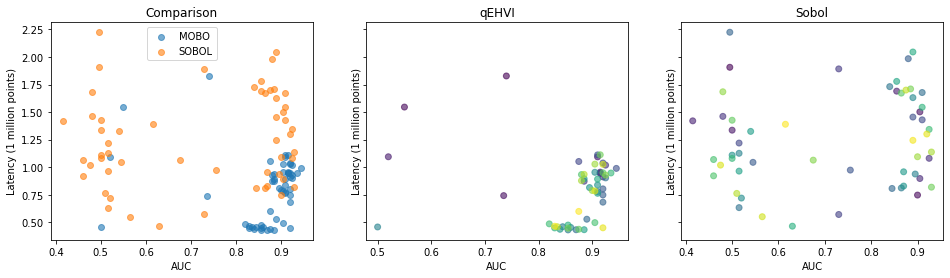

In [ ]:
fig, axs = plt.subplots(1, 3, sharey=True, figsize=(16,4))
axs[0].scatter(mobo_outcomes[:,0], mobo_outcomes[:,1], alpha=0.6, label="MOBO")
axs[0].scatter(random_outcomes[:,0], random_outcomes[:,1], alpha=0.6, label="SOBOL")
axs[0].legend()
axs[0].set_title("Comparison")

axs[1].scatter(mobo_outcomes[:,0], mobo_outcomes[:,1], alpha=0.6, c=range(len(mobo_outcomes[:,0])))
axs[1].set_title("qEHVI")

axs[2].scatter(random_outcomes[:,0], random_outcomes[:,1], alpha=0.6, c=range(len(random_outcomes[:,0])))
axs[2].set_title("Sobol")

for ax in axs.flat:
    ax.set(xlabel="AUC", ylabel="Latency (1 million points)")

fig.show()

The leftmost panel shows a comparison of the two experiments, while the middle and right panels show each experiment individually, with their points colored according to the order in which the trials were run. Notice in the qEHVI panel that earlier trials (purple points) are scattered about (reflecting the initialization phase), while later trials (yellow points) have honed in on the Pareto frontier. The same cannot be said for the Sobol experiment, which samples randomly for all trials. 

Because we generated the dataset randomly, and initialized the sampling randomly, it's likely your results differ from ours (we could of course have mitigated this by fixing seeds for the random number generators, but we're very wary of cherry-picking good results, and wanted to encourage some exploration)! Here's one of the more impressive results we obtained, specifically chosen for its spectacular separation of the qEHVI trials and the Sobol trials. Multi-objective Bayesian optimization (MOBO = qEHVI) found a host of models that are faster _and_ more accurate than Sobol-random search found!

**A pretty great result for qEHVI**

<p><center><img src='https://github.com/sparsh-ai/multiobjective-optimizations/blob/main/docs/_images/T892775_1.png?raw=1'></center></p>

Alas, it's not always the case. In this example, random search actually found the highest AUC model, though it does trade off quite some latency for it.

**A pretty good result for random**

<p><center><img src='https://github.com/sparsh-ai/multiobjective-optimizations/blob/main/docs/_images/T892775_2.png?raw=1'></center></p>

The focus on maximizing the expected hypervolume improvement can lead to a lack of exploration of the wider parts of the hyperparameter space, and sometimes randomly sampling finds better points. Try running the experiments a few times and see what you get!

Ax also provides some visualization helpers, including a handy one to construct the Pareto frontier. The plot below shows the Pareto frontier found by the EHVI algorithm. Note that not all the points on the frontier below were sampled during the optimization process. However, since we now have a posterior model of the map between the input hyperparameters and output (AUC, Latency) space, we can calculate the Pareto frontier based on that model. The uncertainty of that posterior model is reflected in the 90% CI intervals on the frontier points.

In [ ]:
init_notebook_plotting()

frontier = compute_pareto_frontier(
    experiment=mobo_experiment,
    data=mobo_experiment.fetch_data(),
    primary_objective=metric_latency,
    secondary_objective=metric_auc,
    absolute_metrics=["latency", "auc"],
    num_points=50,
)

render(plot_pareto_frontier(frontier, CI_level=0.90)) 

<p><center><img src='https://github.com/sparsh-ai/multiobjective-optimizations/blob/main/docs/_images/T892775_3.png?raw=1'></center></p>

Is EHVI worth the implementation complexity vs random search? It's hard to say from this toy example. It's further hard, in general, to make blanket statements about optimal methods for hyperparameter search, since each problem and search space is different! It's also a slightly unfair question, since the Sobol quasi-random search here is better than regular random search, and the latter is much easier to implement - just use scikit-learn.

## Multi-objective hyperparameter optimization with Optuna

This section walks through a minimal example of multi-objective hyperparameter optimization using the Optuna automatic hyperparameter optimization framework.

First, we need something to learn, so we'll generate a small, toy classification problem. We'll define the metrics we care about: the area under the ROC curve, and prediction latency. Then, we'll use the expected hypervolume improvement (EHVI) to find the Pareto frontier of points that maximize these objectives.

While the official Multi-Objective Optimization with Optuna tutorial provides a fantastic example for PyTorch models, here we demonstrate how to use Optuna with scikit-learn and include a comparison with random sampling for hyperparameter optimization.

In [ ]:
import pickle
import sys
import time
import warnings

import matplotlib.pyplot as plt
import numpy as np
import optuna
import pandas as pd

from sklearn.datasets import make_classification
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

### Data

Let's generate a classification problem. `sklearn` has a helper for that. The exact parameters aren't too important! In this section, we really just want to explore how to use Optuna for multi-objective hyperparameter optimization.

First, we must generate some data, and divide it into a train and development set. We'll train each model on the train set, then 

In [ ]:
X, y = make_classification(n_samples=1000, n_features=40, n_informative=20)

We'll make an 80/20 split and use the larger portion for training, and the smaller portion for evaluation. If the algorithm we trained was going to be used, we'd want a third split to report our final metrics on. As is, we might risk overfitting the hyperparameters to the dev set across many trials. To avoid tripling (or more) the run time, we'll skip cross-validation and simply train each algorithm on the train set, and evaluate on dev. We could get a more robust measure of the metrics associated with each hyperparameter configuration by cross-validating each trial.

In [ ]:
X_train, X_dev, y_train, y_dev = train_test_split(X, y, test_size=0.2, shuffle=True, stratify=y)

### Optimization objectives

Let's say we care about two objectives: the area under the ROC curve (AUC), and latency. AUC captures the quality of a classifier in a threshold-independent way, and is appropriate for the balanced class distribution we have in our toy problem. By optimizing for this, we're finding a good classifier without making a decision about how bad each flavour of misclassification (false positives and false negatives) are, whereas optimizing for a point metric like accuracy directly would be making that call. Latency measures how long a prediction takes. As it turns out, with the scikit-learn multi-layer perceptron model we'll use, not very long. To help smooth out noise in the latency measurement, we'll measure the time required to predict on a batch of a million points.

This will be a small model, and no GPU is used. If we were using a GPU-enabled framework (like PyTorch, TensorFlow, or Jax), we'd need to be a little more careful about how we measure latency (another option is presented in the official Optuna tutorial). Also note that in most applications, we'd probably be more interested in the total response time of a model end point, or the total processing time for a large batch of offline predictions, and it's not necessarily the case that the actual model prediction time is the dominant bottleneck to those things at all!

In [ ]:
million_points = np.repeat(X, 1000, axis=0)

In [ ]:
def roc(model, X, y):
    return roc_auc_score(y, model.predict(X))

def latency(model, X):
    start = time.time()
    model.predict(X)
    end = time.time()
    return end - start

We define a training routine and compute the objectives. The search space for scikit-learn's `MLPClassifier` is roughly the same as that in [Multi-objective multi-fidelity hyperparameter optimization with application to fairness](https://www.amazon.science/publications/multi-objective-multi-fidelity-hyperparameter-optimization-with-application-to-fairness). Notice that this is a tricky search space! We allow up to three layers in the network, and we only want to sample a layer size for those layers that exist. This means `layer_size` is dependent on `n_layers`. Thankfully, Optuna naturally lends itself to hierarchical search spaces like this because it dynamically constructs the hyperparameter search space for each trial (however, this comes with a drawback as we'll see shortly).  

In [ ]:
def train(trial):    
    hidden_layer_sizes = [
        trial.suggest_int(f"layer_{layer+1}_size", 2, 50)
        for layer in range(trial.suggest_int("n_layers", 1, 3))
    ]
    
    pipeline = Pipeline([
        ("scaler", StandardScaler()),
        ("mlp", MLPClassifier(
            solver="adam",
            hidden_layer_sizes=hidden_layer_sizes,
            alpha=trial.suggest_float("alpha", 1e-6, 1.0, log=True),
            tol=trial.suggest_float("tol", 1e-5, 1.0, log=True),
            beta_1=trial.suggest_float("beta_1", 0.001, 0.99),
            beta_2=trial.suggest_float("beta_2", 0.001, 0.99),
            learning_rate_init=trial.suggest_float("learning_rate_init", 1e-6, 1e-1, log=True)
        ))
    ])
    
    pipeline.fit(X_train, y_train)
    auc = roc(pipeline, X_dev, y_dev)
    lat = latency(pipeline, million_points)

    return auc, lat

### Experiment setup

We'll run two hyperparameter searches: one using the expected hypervolume improvement (EHVI), and another with pseudo-random sampling for comparison. Optuna initializes the EHVI model for generating new hyperparameter configs with a few random points before performing a fixed number of trials, a process that is performed automatically under-the-hood. 

In [ ]:
N_TRIAL = 55  # number of trials to run after initialization

We're just about ready to cleverly optimize our hyperparameters. For this experiment we'll use the MOTPE algorithm detailed in [Multiobjective tree-structured parzen estimator for computationally expensive optimization problems](https://dl.acm.org/doi/10.1145/3377930.3389817). This algorithm uses tree-structured parzen estimators as the surrogate function and EHVI as the acquisition function. We explained how these algorithms work in [Exploring Multi-Objective Hyperparameter Optimization](https://blog.fastforwardlabs.com/2021/07/07/exploring-multi-objective-hyperparameter-optimization.html). In a nutshell, we create a model that takes hyperparameters as inputs and predicts the resultant optimization objectives as outputs. We use this model to find the input hyperparameter combination that will most improve the hypervolume thus expanding the Pareto frontier. Then, we try that hyperparameter config, generating a new data point with which to improve our model, and loop this whole procedure `N_TRIAL` times.

In [ ]:
motpe_sampler = optuna.samplers.MOTPESampler()
motpe_experiment = optuna.create_study(sampler=motpe_sampler, directions=["maximize", "minimize"])
motpe_experiment.optimize(train, n_trials=N_TRIAL)

<ipython-input-8-88b9b9235eb2>:1: ExperimentalWarning: MOTPESampler is experimental (supported from v2.4.0). The interface can change in the future.
  motpe_sampler = optuna.samplers.MOTPESampler()
[I 2021-06-24 13:33:08,291] A new study created in memory with name: no-name-2683aec9-a927-43aa-a061-b67e320433a8
[I 2021-06-24 13:33:09,437] Trial 0 finished with values: [0.8450000000000001, 0.8262290954589844] and parameters: {'n_layers': 3, 'layer_1_size': 5, 'layer_2_size': 46, 'layer_3_size': 41, 'alpha': 9.16429681464628e-06, 'tol': 4.4073149861688505e-05, 'beta_1': 0.34931254944477413, 'beta_2': 0.9232175410049337, 'learning_rate_init': 0.011713650842477602}. 
[I 2021-06-24 13:33:10,384] Trial 1 finished with values: [0.8999999999999999, 0.8827610015869141] and parameters: {'n_layers': 3, 'layer_1_size': 47, 'layer_2_size': 30, 'layer_3_size': 33, 'alpha': 0.000497863420997646, 'tol': 0.042431076986822885, 'beta_1': 0.40591916231423836, 'beta_2': 0.409687630011716, 'learning_rate_ini

[I 2021-06-24 13:33:24,682] Trial 21 finished with values: [0.8900000000000001, 0.34682798385620117] and parameters: {'n_layers': 1, 'layer_1_size': 7, 'alpha': 0.4220468928331617, 'tol': 0.9205855947906584, 'beta_1': 0.1355045696452603, 'beta_2': 0.12358877798741968, 'learning_rate_init': 0.026215233749186093}. 
[I 2021-06-24 13:33:25,363] Trial 22 finished with values: [0.885, 0.5584681034088135] and parameters: {'n_layers': 2, 'layer_1_size': 2, 'layer_2_size': 37, 'alpha': 0.05927541209993249, 'tol': 0.0029859542692567418, 'beta_1': 0.276718698028048, 'beta_2': 0.6467856636383467, 'learning_rate_init': 0.005313774791799439}. 
[I 2021-06-24 13:33:25,820] Trial 23 finished with values: [0.8949999999999999, 0.39627814292907715] and parameters: {'n_layers': 1, 'layer_1_size': 17, 'alpha': 0.003966062336361071, 'tol': 0.022560292596133607, 'beta_1': 0.14092242274995986, 'beta_2': 0.8719943100057457, 'learning_rate_init': 0.0773444843114371}. 
[I 2021-06-24 13:33:26,580] Trial 24 finishe

[I 2021-06-24 13:33:39,400] Trial 44 finished with values: [0.9000000000000001, 0.35135507583618164] and parameters: {'n_layers': 1, 'layer_1_size': 7, 'alpha': 1.057434176380296e-05, 'tol': 6.707959414130896e-05, 'beta_1': 0.06619735461953394, 'beta_2': 0.07107971291956858, 'learning_rate_init': 0.005405215145553146}. 
[I 2021-06-24 13:33:39,876] Trial 45 finished with values: [0.855, 0.323167085647583] and parameters: {'n_layers': 1, 'layer_1_size': 2, 'alpha': 0.030428082581132613, 'tol': 0.00040121967401255234, 'beta_1': 0.16804638046778253, 'beta_2': 0.17554668696202536, 'learning_rate_init': 0.053521417432980556}. 
[I 2021-06-24 13:33:40,449] Trial 46 finished with values: [0.905, 0.3662989139556885] and parameters: {'n_layers': 1, 'layer_1_size': 10, 'alpha': 0.0007266574593452988, 'tol': 1.0102977147122388e-05, 'beta_1': 0.5207391537224039, 'beta_2': 0.9804189824133966, 'learning_rate_init': 0.02066479427739678}. 
/opt/anaconda3/envs/hpo/lib/python3.9/site-packages/sklearn/neur

As a trade off to the flexibility of a define-by-run hyperparameter space, Optuna’s random search is suboptimal for problems with a fixed, non-dynamic hyperparameter space. Unlike Ax's use of Sobol random, Optuna uses the `numpy` RandomState class to generate independent samples from the parameter space. You can read more about the difference between these types of random sampling in our main blog post (TODO: link again (to the specific section))? 

However, generating an experiment with random sampling is as easy as changing the sampler!

In [ ]:
random_sampler = optuna.samplers.RandomSampler()
random_experiment = optuna.create_study(sampler=random_sampler, directions=["maximize", "minimize"])
random_experiment.optimize(train, n_trials=N_TRIAL, timeout=300)

[I 2021-06-24 13:33:45,156] A new study created in memory with name: no-name-f5ea743f-5351-4c94-bb3b-073cfc71208a
[I 2021-06-24 13:33:45,526] Trial 0 finished with values: [0.855, 0.3397219181060791] and parameters: {'n_layers': 1, 'layer_1_size': 5, 'alpha': 1.6583798916713135e-06, 'tol': 0.04131954057651528, 'beta_1': 0.03944237992080375, 'beta_2': 0.7740661460724664, 'learning_rate_init': 0.04852577351926202}. 
[I 2021-06-24 13:33:46,086] Trial 1 finished with values: [0.8949999999999999, 0.5287368297576904] and parameters: {'n_layers': 1, 'layer_1_size': 42, 'alpha': 0.9963429830202633, 'tol': 0.09246280379558958, 'beta_1': 0.7195088193468046, 'beta_2': 0.29885617879226084, 'learning_rate_init': 0.06860857380535164}. 
[I 2021-06-24 13:33:46,747] Trial 2 finished with values: [0.64, 0.623384952545166] and parameters: {'n_layers': 2, 'layer_1_size': 36, 'layer_2_size': 19, 'alpha': 3.1382750520930222e-06, 'tol': 0.008763082630036568, 'beta_1': 0.7933874414978763, 'beta_2': 0.32699564

[I 2021-06-24 13:34:03,977] Trial 21 finished with values: [0.875, 0.6066792011260986] and parameters: {'n_layers': 2, 'layer_1_size': 50, 'layer_2_size': 3, 'alpha': 0.0007933111984618153, 'tol': 0.04194318984051112, 'beta_1': 0.942039711044863, 'beta_2': 0.8655986481594887, 'learning_rate_init': 0.010487012710084159}. 
/opt/anaconda3/envs/hpo/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
[I 2021-06-24 13:34:04,760] Trial 22 finished with values: [0.55, 0.40920495986938477] and parameters: {'n_layers': 1, 'layer_1_size': 15, 'alpha': 0.08577432928050567, 'tol': 0.0005611833437950967, 'beta_1': 0.06544242583279844, 'beta_2': 0.1581465699036227, 'learning_rate_init': 2.9969661296918156e-05}. 
[I 2021-06-24 13:34:05,612] Trial 23 finished with values: [0.5, 0.7926290035247803] and parameters: {'n_layers': 3, 'layer_1_si

[I 2021-06-24 13:34:23,036] Trial 40 finished with values: [0.6000000000000001, 0.5281221866607666] and parameters: {'n_layers': 1, 'layer_1_size': 35, 'alpha': 0.0012641283486926052, 'tol': 0.9282753886154791, 'beta_1': 0.37774095460471235, 'beta_2': 0.6407286452574744, 'learning_rate_init': 1.977844210971094e-06}. 
[I 2021-06-24 13:34:23,420] Trial 41 finished with values: [0.485, 0.35796308517456055] and parameters: {'n_layers': 1, 'layer_1_size': 5, 'alpha': 1.3989383647500107e-05, 'tol': 0.038166776868459595, 'beta_1': 0.5631958946498815, 'beta_2': 0.6935417098351765, 'learning_rate_init': 3.241404263654068e-06}. 
[I 2021-06-24 13:34:24,553] Trial 42 finished with values: [0.8900000000000001, 0.9083409309387207] and parameters: {'n_layers': 3, 'layer_1_size': 27, 'layer_2_size': 26, 'layer_3_size': 34, 'alpha': 1.123847998137992e-05, 'tol': 0.0018205660184223804, 'beta_1': 0.3326677975728737, 'beta_2': 0.1256364390286232, 'learning_rate_init': 0.0017725719114662698}. 
[I 2021-06-2

We provide a helper function that casts the output of the Optuna experiments into an easier-to-read format. 

In [ ]:
# Helper function that 
def cast_as_df(optuna_experiment, experiment_type):
    df = (
        optuna_experiment
        .trials_dataframe()
        .rename(columns={"values_0": "auprc", "values_1": "latency"})
        .assign(experiment = experiment_type)
    )
    # the following lines create a column identifing which of the trials resulted in a
    # Best configuration -- a model with these HPs lies along the empirical Pareto frontier
    best_trials = [trial.number for trial in optuna_experiment.best_trials]
    df['best_trial'] = np.where(df.number.isin(best_trials), 1, 0)
    return df

In [ ]:
motpe_df = cast_as_df(motpe_experiment, "MOTPE")
random_df = cast_as_df(random_experiment, "Random")

### Visualize Results

We can visually compare the results of MOPTE and random sampling. We want to see a Pareto frontier of points in the lower right corner of the chart - points with the highest accuracy and lowest latency possible.

<ipython-input-12-2d3c23fbdebc>:16: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


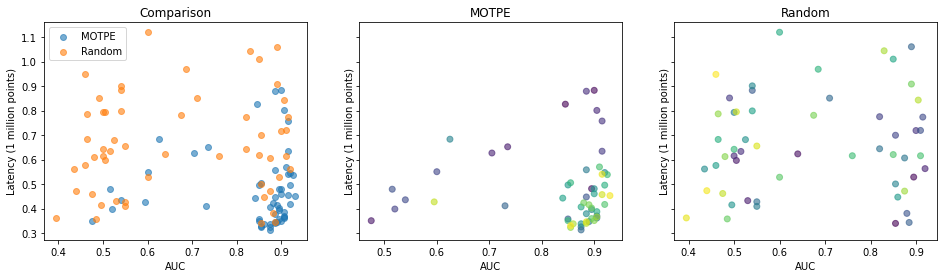

In [ ]:
fig, axs = plt.subplots(1, 3, sharey=True, figsize=(16,4))
axs[0].scatter(motpe_df.auprc, motpe_df.latency, alpha=0.6, label=motpe_df.experiment[0])
axs[0].scatter(random_df.auprc, random_df.latency, alpha=0.6, label=random_df.experiment[0])
axs[0].legend()
axs[0].set_title("Comparison")

axs[1].scatter(motpe_df.auprc, motpe_df.latency, alpha=0.6, c=motpe_df.number)
axs[1].set_title(motpe_df.experiment[0])

axs[2].scatter(random_df.auprc, random_df.latency, alpha=0.6, c=random_df.number)
axs[2].set_title(random_df.experiment[0])

for ax in axs.flat:
    ax.set(xlabel="AUC", ylabel="Latency (1 million points)")

fig.show()

The leftmost panel shows a comparison of the two experiments, while the middle and right panels show each experiment individually, with their points colored according to the order in which the trials were run. Notice in the MOTPE panel that earlier trials (purple points) are scattered about (reflecting the initialization phase), while later trials (yellow points) have honed in on the Pareto frontier. The same cannot be said for the random experiment, which samples randomly for all trials. 

Because we generated the dataset randomly, and initialized the sampling randomly, it's likely your results differ from ours (we could of course have mitigated this by fixing seeds for the random number generators, but we're very wary of cherry-picking good results, and wanted to encourage some exploration)!  If you've already taken a look at our similar [tutorial using the Ax library](https://github.com/fastforwardlabs/multi-objective-hyperparameter-optimization/tree/master/ax-on-synthetic-data), you might notice that MOTPE and Random are often far more separated than Sobol vs qEVHI in that section. While a host of factors contribute to why, we'll mention two explicitly:
1. MOTPE's tree-structured surrogate model (rather than the GP surrogate model used by the Ax library) is likely better suited for hierarchical hyperparameter spaces like that explored here
2. Not all random sampling is equal: Sobol random sampling (in the Ax section) provides better coverage than pseudo-random sampling (in this section) over fixed hyperparamter spaces.  


With that said, here's an example of one of the more impressive results we obtained, specifically chosen for its spectacular separation of the MOTPE trials and the random trials. Multi-objective Bayesian optimization found a host of models that are faster _and_ more accurate than random search found!

 


**A pretty great result for MOTPE**

<p><center><img src='https://github.com/sparsh-ai/multiobjective-optimizations/blob/main/docs/_images/T892775_4.png?raw=1'></center></p>

But sometimes, even when MOTPE performs better, it's not always clear why. For example, in the figure below, MOTPE unequivocally better samples the Pareto frontier, but if we look at the order in which those trials were run, these Pareto-esque points were found very early in the optimization (dark purple) and then the algorithm moved _away_ from the Pareto frontier in the remaining trials, as indicated by the yellow points being scattered all over. So we might just have got lucky this time. 

**A strange result for MOTPE**

<p><center><img src='https://github.com/sparsh-ai/multiobjective-optimizations/blob/main/docs/_images/T892775_5.png?raw=1'></center></p>

## Multi-objective hyperparameter optimization for credit card fraud

In multi-objective hyperparameter optimization, we seek to find the "Pareto frontier" of points representing optimal tradeoffs between multiple objectives. In this example, we trade off prediction latency with predictive performance. The class distribution is heavily imbalanced, so we measure performance with the area under the PR curve. The section compares a Bayesian optimization algorithm: maximizing the expected hypervolume increase (EHVI) using multi-objective tree-structured Parzen estimators (MOTPE), with good old random search.

In [ ]:
!pip install -q -U kaggle
!pip install --upgrade --force-reinstall --no-deps kaggle
!mkdir ~/.kaggle
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d mlg-ulb/creditcardfraud

     |████████████████████████████████| 58 kB 4.4 MB/s 
  Created wheel for kaggle: filename=kaggle-1.5.12-py3-none-any.whl size=73051 sha256=e242ead18420b915ef01a5ebde5538c731c340ab748dd8772d81ee146918beb7
  Stored in directory: /root/.cache/pip/wheels/62/d6/58/5853130f941e75b2177d281eb7e44b4a98ed46dd155f556dc5
Successfully built kaggle
  Attempting uninstall: kaggle
    Found existing installation: kaggle 1.5.12
    Uninstalling kaggle-1.5.12:
      Successfully uninstalled kaggle-1.5.12
 74% 49.0M/66.0M [00:00<00:00, 65.3MB/s]
100% 66.0M/66.0M [00:00<00:00, 76.7MB/s]


## Multi-objective hyperparameter optimization for Credit Card Fraud with Optuna

### A tale of two tradeoffs

Credit card fraud is a nice problem, from a machine learning perspective, because (at least in it's naive version) it's a straightforward binary classification that very likely has a real attributable amount of money associated with true and false positives and negatives. As such, there’s a genuine optimization problem a bank can perform on how to trade off precision and recall. For example, a false positive labels a legit transaction as fraud. While this might be annoying for existing customers who have to call the bank and verify their purchase, it does not result in lost revenue. On the other hand, a false negative labels a fraudulent transaction as legit, and this has significant costs, both in terms of lost revenue and a potentially angry customer. 

While we _could_ train a model to minimize false negatives (FN) or false positives (FP), or even accuracy -- these come with considerable drawbacks. Minimizing either of FPs or FNs ignores the impact of the other. Even worse, as business needs change (say, the real cost associated with FPs increases) then a new model must be trained from scratch to address the updated business requirements. Optimizing for pure accuracy might be okay for balanced datasets but leads to overly-optimistic models when working with unbalanced datasets (since the model can achieve a high score by simply labeled _everything_ as nonfraudulent).

In reality, the precision-recall tradeoff is ultimately a _business decision_ and should be made in conversation with expert business stakeholders. As machine learning engineers, our job is to give the business stakeholder the most favourable precision and recall curve possible, so that we trade off the least amount of precision for recall, or vice versa. To do this, we’ll optimize for the area under the PR curve (AUPRC). A model optimized for AUPRC can be used at several thresholds without retraining to accomodate evolving business needs. Additionally, AUPRC is meaningful even for imbalanced datasets, and credit card fraud is highly imbalanced; most transactions are not fraudulent.

But there is another relevant tradeoff to consider! Not only should our model have strong predictive power, it should also be fast at making predictions. Fraudulent transactions should be detected quickly to reduce the most harm, and there may even be a hard constraint on the allowable latency from prediction. So we actually care about both AUPRC and latency. Unfortunately, there is no way for a single model to exhibit a wide range of AUPRC-latency values -- there's no "threshold" to sweep across like there is with precision vs recall. Instead, each model we train will have a different combination of predictive power and latency (inherited by our choice of hyperparameters) and our job will be to find the _set_ of such models that represent the optimal tradeoffs between the two. This sounds like a job for multi-objective Bayesian optimization!

In this section, we'll demonstrate how to perform multi-objective Bayesian optimization to a canonical credit card fraud dataset. We'll consider an XGBoost model for several reasons: 
1. it's a powerful and well-known algorithm that works in many situations
2. tree-based models often have prediction efficacy -- prediction latency tradeoffs: more/deeper trees usually provide better predictions but generally take longer at inference time
3. XGBoost has many hyperparameters in addition to `max_depth` that we might wish to optimize, and their relationship with our output objectives (AUPRC and latency) is unclear

Below we start with some install and imports. 

In [ ]:
import time
import warnings

import matplotlib.pyplot as plt
import numpy as np
import optuna
import pandas as pd
import seaborn as sns
import xgboost as xgb

from sklearn.metrics import auc, precision_recall_curve
from sklearn.model_selection import cross_validate, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

In [ ]:
warnings.filterwarnings('ignore')

### Data

In this section we use the anonymized [Credit Card Fraud dataset on Kaggle](https://www.kaggle.com/mlg-ulb/creditcardfraud). Sign-in is required to download this dataset. We have already performed this step and stored the dataset at `[project_directory]/data`, so we'll load it from there.  

The data comes somewhat pre-feature-engineered, having gone through (at least) PCA. This was done in the name of privacy preservation, but also means the data is in reasonable shape to put directly into a supervised learning pipeline.

In an unrealistic (but possibly good) assumption, we'll exclude the time variable and treat the remaining features as i.i.d. While it's possbile that fraudulent transactions are more likely at a certain time, creating a classifier that discriminates on the basis of time presents an easily-exploitable means of improving the likelihood of a successful fraudulent transaction, as an adversary. It's likely that time is confounded with the other variables from which features were derived. Unfortunately, we have no way of knowing. Causal inference always requires model assumptions, and is impossible with obfuscated variables.

The task is "point-like" prediction of fraud, in the sense that transactions are not linked by any ID, so we can do no analysis of events from the same card over time. As such, each incoming datapoint will be subject to a prediction independent of the others. Time could be used as a feature, but only in the naive sense (time of day, etc). Neglecting time seems appropriate for this point-like prediction task.

In [ ]:
cc = pd.read_csv("creditcard.csv").drop("Time", axis="columns")

We'll also separate the label column (`Class`) from the features in the dataset. 

In [ ]:
X = cc.drop("Class", axis="columns")
y = cc.Class

The target classes are heavily imbalanced.

In [ ]:
class_counts = cc.Class.value_counts()

print(f"""
There are {class_counts[1]} identified cases of fraud in {class_counts.sum()} total cases.
That's only {100 * class_counts[1]/class_counts.sum():.2f}%!
""")


There are 492 identified cases of fraud in 284807 total cases.
That's only 0.17%!



Next we'll perform a standard train/dev split. However, if this model were to be put into production, we'd want to also create a dev/test split so as not to overfit to our dev set. 

In [ ]:
X_train, X_dev, y_train, y_dev = train_test_split(X, y, test_size=0.3, shuffle=True, stratify=y)

There are no missing entries in the data set.

In [ ]:
cc.isna().any(axis=None)

False

We now have a set of features `V1` through `V28` which are the output of the privacy-preserving PCA for each transaction, along with the `Amount` column. Let's get a feel for how these features look and how they compare across classes. 

In [ ]:
X_train.describe()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
count,199364.000000,199364.000000,199364.000000,199364.000000,199364.000000,199364.000000,199364.000000,199364.000000,199364.000000,199364.000000,...,199364.000000,199364.000000,199364.000000,199364.000000,199364.000000,199364.000000,199364.000000,199364.000000,199364.000000,199364.000000
mean,0.002782,-0.001017,-0.001026,-0.000179,0.001403,0.001152,0.002189,-0.001126,-0.000176,-0.001169,...,-0.001221,-0.000514,0.000803,-0.000591,0.000665,0.000083,-0.000136,-0.000114,-0.000129,88.424873
std,1.955035,1.650328,1.509339,1.413776,1.363592,1.326988,1.217031,1.190037,1.098078,1.083900,...,0.772523,0.732521,0.726467,0.636842,0.605492,0.522166,0.482836,0.400808,0.327791,249.621608
min,-41.928738,-63.344698,-32.965346,-5.683171,-40.427726,-21.929312,-43.557242,-50.688419,-13.434066,-24.588262,...,-28.009635,-22.889347,-10.933144,-44.807735,-2.836627,-10.295397,-2.604551,-22.565679,-11.710896,0.000000
25%,-0.919352,-0.596672,-0.891617,-0.847025,-0.690694,-0.768760,-0.553161,-0.209098,-0.641332,-0.535903,...,-0.212083,-0.228452,-0.542162,-0.161974,-0.354043,-0.317239,-0.327428,-0.070636,-0.052863,5.520000
50%,0.021603,0.066449,0.177854,-0.019554,-0.054717,-0.274843,0.041344,0.021957,-0.050598,-0.093471,...,-0.063053,-0.029246,0.007802,-0.011077,0.041296,0.017396,-0.053530,0.001343,0.011316,21.960000
75%,1.315787,0.802569,1.025892,0.741960,0.614586,0.400368,0.573119,0.327845,0.595768,0.452529,...,0.132733,0.186195,0.530376,0.147431,0.440686,0.350621,0.241311,0.091280,0.078230,76.900000
max,2.454930,22.057729,9.382558,16.875344,32.911462,23.917837,44.054461,19.587773,15.594995,23.745136,...,39.420904,27.202839,8.361985,22.528412,4.022866,7.519589,3.463246,12.152401,22.620072,19656.530000


Maybe some features will be well correlated with the target. Let's do a visual spot check. Because there's such a huge class imbalance, we randomly downsample the dominant class to match the prevalence of the minority class.

In [ ]:
melted_cc = (
    pd.concat([cc[cc.Class == 1], cc[cc.Class == 0].sample(492)])#
    .drop("Amount", axis="columns")
    .melt(id_vars=["Class"],
          value_vars=[c for c in cc.columns if c not in ["Class", "Amount"]])
)

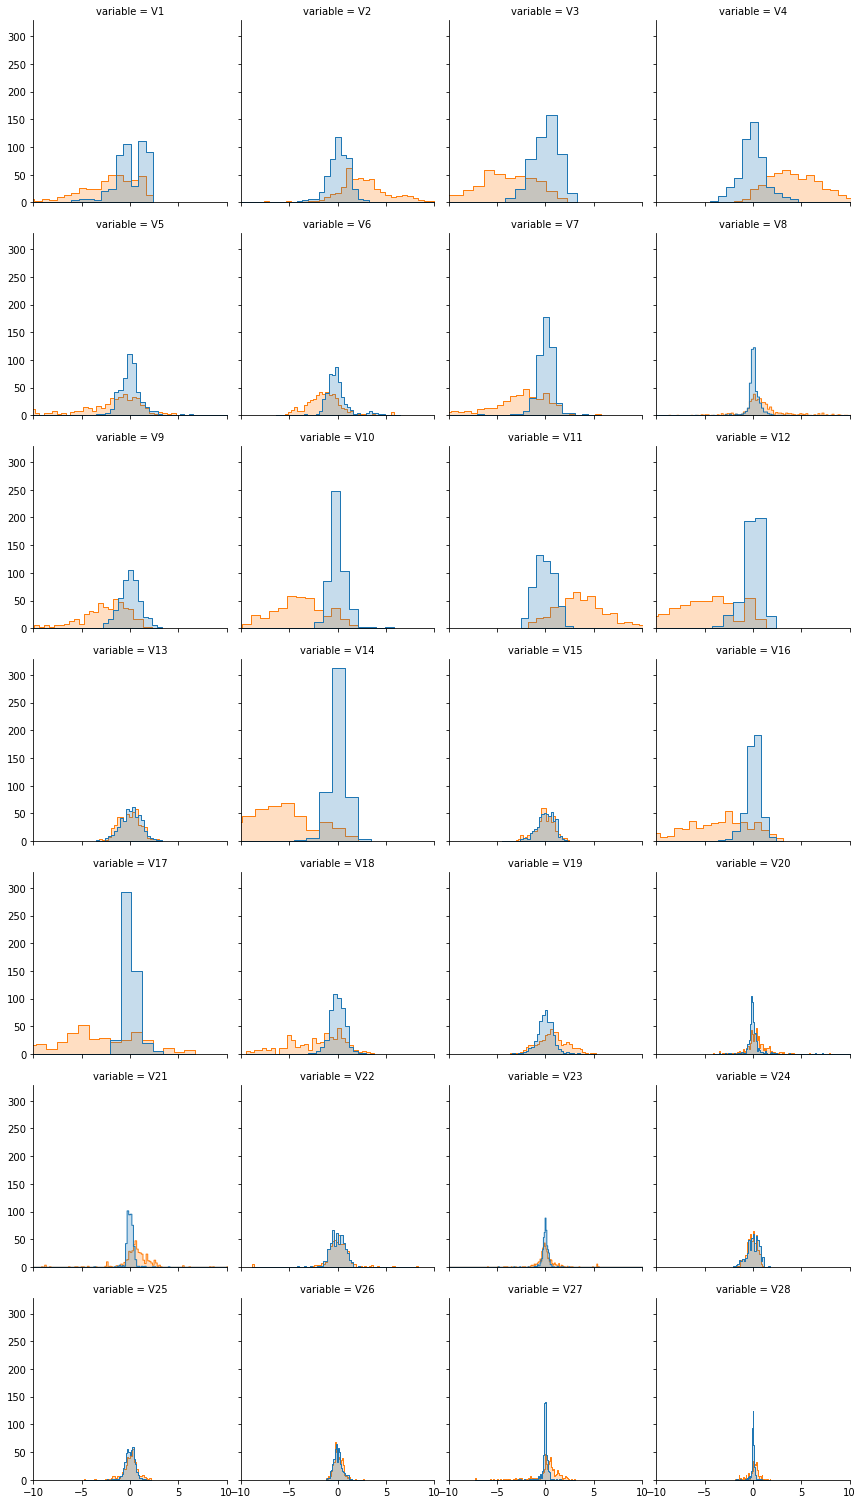

In [ ]:
grid = sns.FacetGrid(melted_cc, col="variable", col_wrap=4)
grid.map_dataframe(sns.histplot, x="value", hue="Class", element="step")
grid.set(xlim=(-10,10))

The scale of the `Amount` variable differs from the PCA variables above, so we plot it separately (again, downsampling non-fraudulent transactions).

<AxesSubplot:xlabel='Amount', ylabel='Count'>

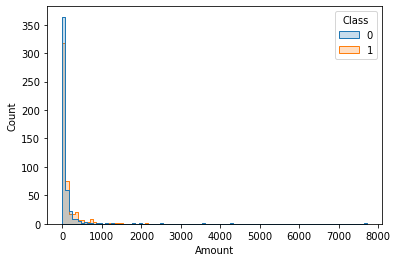

In [ ]:
sns.histplot(
    pd.concat([cc[cc.Class == 1], cc[cc.Class == 0].sample(492)]), # downsample
    x="Amount", hue="Class", element="step", bins=100
)

The distribution of fraudulent transactions looks relatively well spread over the transaction size (recalling that downsampling non-fraudulent transactions so severely introduces a lot of statistical noise - run the function repeatedly to draw new samples). It looks like there's some reasonable separation between some of the PCA feature distributions though. This signals that there's a good chance we can learn to discriminate fraudulent transactions on the basis of these features. (Even those distributions that overlap extremely well may be useful in combination with other features).

Another thing to note is that the features are not perfect standard normal distributions, but are all close to mean zero and standard deviation one, except the transaction amount. Taking all features `V1` through `V28` and `Amount` as our feature matrix, we can apply standard scaling to all (it will not harm those already scaled, and performance is not a concern). 

Now that we have a good idea about the distribution of our data and the features we have to work with, it's time to find the set of models that optimize the AUPRC-latency multi-objective space. 

### Hyperparameter optimization with Optuna

The first step on our optimization journey is to define our optimization targets. We have two: AUPRC and latency. Measuring AUPRC is straightforward with `sklearn`. For latency, we'll time how long it takes to infer on one million randomly sampled datapoints.

In [ ]:
million_points = X_train.sample(int(1e6), replace=True)

In [ ]:
def area_under_pr_curve(model, X, y):
    precision, recall, _ = precision_recall_curve(y, model.predict(X))
    area = auc(recall, precision)
    return area

def latency(model, X):
    start = time.time()
    model.predict(X)
    end = time.time()
    return end - start

### Training routine
Next we define the training routine that will allow Optuna to perform hyperparameter optimization. We pass the function a `trial` object through which Optuna will suggest a new value for each hyperparameter according to a pre-defined sampling strategy for each trial we run. 

**Note:** Optuna will train and evaluate a model for each trial. While the hyperparameter values, metric scores, and additional metadata are saved from each trial, the model itself is discarded. This means we would have to retrain our preferred model once optimization was complete. For most cases, this isn't an issue, however it is possible to save each model to disk during the optimization loop. Models of interest can then be fetched using the associated trial number.

In [ ]:
def train(trial):
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('xgboost', xgb.XGBClassifier(
            eval_metric = "logloss",
            use_label_encoder = False,
            learning_rate =    trial.suggest_float("learning_rate", 1e-6, 1, log=True),
            n_estimators =     trial.suggest_int("n_estimators", 1, 500),
            gamma =            trial.suggest_float("gamma", 1e-6, 1e1, log=True),
            max_depth =        trial.suggest_int("max_depth", 1, 20),
            min_child_weight = trial.suggest_float("min_child_weight", 1, 10),
            max_delta_step =   trial.suggest_float("max_delta_step", 0, 10),
            subsample =        trial.suggest_float("subsample", 0.2, 1),
            reg_lambda =       trial.suggest_float("lambda", 0, 10),
            reg_alpha =        trial.suggest_float("alpha", 0, 10)
        ))
    ])

    # if we were patient, we could cross-validate here and
    # report metrics on the average hold-out score
    pipeline.fit(X_train, y_train)
    
    # evaluate metrics
    auprc = area_under_pr_curve(pipeline, X_dev, y_dev)
    lat = latency(pipeline, million_points)

    # save a trained model to a file
    if SAVE_MODELS:
        with open("../output/models/{}.pickle".format(trial.number), "wb") as fout:
            pickle.dump(pipeline, fout)
    
    return auprc, lat

### Experiment setup

We'll first use a multi-objective Bayesian optimization algorithm (MOTPE) to cleverly sample hyperparameter values that (hopefully) optimize both our objectives. You can read more about how the MOTPE algorithm works in our blog post [Exploring Multi-Objective Hyperparameter Optimization](https://blog.fastforwardlabs.com/2021/07/07/exploring-multi-objective-hyperparameter-optimization.html).

Setting up an experiment is easy. The first line defines the sampling strategy. The second creates an Optuna `study` which tracks the details of the optimization run. For this, we need to tell Optuna how to optimize our objectives. In this case we want to _maximize_ AUPRC and _minimize_ latency. The order should reflect the order in which the values are passed out from the `train` routine above. Finally, we execute the experiment with a call to the `optimize` method, where we pass it the function we wish to optimize along with the number of trials for the optimization process. 

**Note:** The experiments in this section take a considerable amount of time to execute since each performs 50 trials and each trial trains a new XGBoost model on 200K credit card transactions. Expect these cells to take several minutes or more, depending on your hardware. If you don't want to wait, we've included a set of results from our experiments that you can examine in the next section. 

In [ ]:
N_TRIAL = 50
SAVE_MODELS = False

In [ ]:
motpe_sampler = optuna.samplers.MOTPESampler()
motpe_experiment = optuna.create_study(sampler=motpe_sampler, directions=["maximize", "minimize"])
motpe_experiment.optimize(train, n_trials=N_TRIAL)

[I 2021-06-24 20:46:20,545] A new study created in memory with name: no-name-fd328da8-cd5e-4bf5-84b5-7ea6bcfb3561
[I 2021-06-24 20:46:27,486] Trial 0 finished with values: [0.7218528003744463, 0.6946229934692383] and parameters: {'learning_rate': 0.0001758226885007034, 'n_estimators': 258, 'gamma': 0.000254816035807138, 'max_depth': 1, 'min_child_weight': 1.5844561218068764, 'max_delta_step': 7.269360054927513, 'subsample': 0.21175314615388371, 'lambda': 9.398630749093787, 'alpha': 4.86142669944999}. 
[I 2021-06-24 20:46:59,324] Trial 1 finished with values: [0.8099176061326265, 1.3288612365722656] and parameters: {'learning_rate': 0.0006278354697490014, 'n_estimators': 253, 'gamma': 0.00010440178614951517, 'max_depth': 16, 'min_child_weight': 6.102792411013507, 'max_delta_step': 8.974872787219288, 'subsample': 0.5194152189405955, 'lambda': 1.9968383305021187, 'alpha': 0.5159333571793945}. 
[I 2021-06-24 20:47:21,222] Trial 2 finished with values: [0.7893394252069803, 1.108752250671386

[I 2021-06-24 20:56:02,791] Trial 20 finished with values: [0.8633044164736345, 0.7527987957000732] and parameters: {'learning_rate': 0.8943000035466402, 'n_estimators': 39, 'gamma': 0.0009374759777297474, 'max_depth': 10, 'min_child_weight': 2.7972723804638853, 'max_delta_step': 9.715767719674412, 'subsample': 0.7345387773887169, 'lambda': 6.438201070530747, 'alpha': 5.291548608701597}. 
[I 2021-06-24 20:56:11,339] Trial 21 finished with values: [0.8242881215957178, 0.66837477684021] and parameters: {'learning_rate': 0.01570830514132692, 'n_estimators': 44, 'gamma': 0.0005843419549110167, 'max_depth': 10, 'min_child_weight': 3.451703160815641, 'max_delta_step': 5.970869095086018, 'subsample': 0.7855819304167373, 'lambda': 6.640877751460141, 'alpha': 9.931482531919947}. 
[I 2021-06-24 20:56:31,464] Trial 22 finished with values: [0.8190593634257831, 0.9080891609191895] and parameters: {'learning_rate': 1.2132474088146525e-06, 'n_estimators': 123, 'gamma': 5.6973247272204155e-05, 'max_d

[I 2021-06-24 21:01:44,028] Trial 41 finished with values: [0.8960887077034426, 1.3205640316009521] and parameters: {'learning_rate': 0.35255531082952624, 'n_estimators': 299, 'gamma': 0.0022554428603927803, 'max_depth': 11, 'min_child_weight': 1.4326160029393387, 'max_delta_step': 9.23833054166008, 'subsample': 0.5924575269082281, 'lambda': 6.279056012760253, 'alpha': 3.900550166331861}. 
[I 2021-06-24 21:02:18,902] Trial 42 finished with values: [0.8869709470943627, 0.8983578681945801] and parameters: {'learning_rate': 0.9164021354316638, 'n_estimators': 420, 'gamma': 2.836435332224698e-05, 'max_depth': 16, 'min_child_weight': 1.0383833612085256, 'max_delta_step': 8.23276279240983, 'subsample': 0.6925163909114869, 'lambda': 5.934725798512234, 'alpha': 5.597046742001425}. 
[I 2021-06-24 21:03:36,769] Trial 43 finished with values: [0.8790418265455769, 2.0225112438201904] and parameters: {'learning_rate': 0.055299118251327245, 'n_estimators': 453, 'gamma': 0.000260614052481391, 'max_de

Our second experiment will use random sampling for optimization. The only thing that needs to change is the sampling strategy. 

In [ ]:
random_sampler = optuna.samplers.RandomSampler()
random_experiment = optuna.create_study(sampler=random_sampler, directions=["maximize", "minimize"])
random_experiment.optimize(train, n_trials=N_TRIAL)

[I 2021-06-24 21:07:32,414] A new study created in memory with name: no-name-c5e5c759-7e1d-4441-a31f-7819463f106d
[I 2021-06-24 21:08:08,251] Trial 0 finished with values: [0.8242881215957178, 1.2239470481872559] and parameters: {'learning_rate': 1.9507239259377863e-06, 'n_estimators': 271, 'gamma': 3.203084164333884e-05, 'max_depth': 12, 'min_child_weight': 3.9081575799327846, 'max_delta_step': 4.117412038341683, 'subsample': 0.5762772304746615, 'lambda': 5.405463628427972, 'alpha': 3.864109226147682}. 
[I 2021-06-24 21:08:18,362] Trial 1 finished with values: [0.8296505703197883, 0.6600246429443359] and parameters: {'learning_rate': 0.01655164453347855, 'n_estimators': 58, 'gamma': 3.9044873735601247, 'max_depth': 13, 'min_child_weight': 7.984927170467948, 'max_delta_step': 8.09500795905697, 'subsample': 0.849813279677957, 'lambda': 7.3365891345582455, 'alpha': 2.2537196445796215}. 
[I 2021-06-24 21:08:24,360] Trial 2 finished with values: [0.7962364659054924, 0.6288399696350098] and

[I 2021-06-24 21:17:56,898] Trial 20 finished with values: [0.8110071208354481, 1.5800440311431885] and parameters: {'learning_rate': 2.0884008896526032e-06, 'n_estimators': 455, 'gamma': 2.891243616832569e-06, 'max_depth': 15, 'min_child_weight': 5.035721547860057, 'max_delta_step': 8.70477440647167, 'subsample': 0.3385504407877148, 'lambda': 2.7435598630534397, 'alpha': 0.6978146783305916}. 
[I 2021-06-24 21:18:00,515] Trial 21 finished with values: [0.8641084498468754, 0.5938787460327148] and parameters: {'learning_rate': 0.5793789316528507, 'n_estimators': 32, 'gamma': 0.052375508713541845, 'max_depth': 9, 'min_child_weight': 7.430893761258581, 'max_delta_step': 6.395150246442426, 'subsample': 0.4435405009843316, 'lambda': 3.0110480701804763, 'alpha': 6.4509483120277125}. 
[I 2021-06-24 21:18:18,926] Trial 22 finished with values: [0.8084182064818278, 0.9187440872192383] and parameters: {'learning_rate': 0.0002872486380637588, 'n_estimators': 160, 'gamma': 8.128741037256317e-05, 'm

[I 2021-06-24 21:27:28,994] Trial 41 finished with values: [0.7948569290121553, 0.8213651180267334] and parameters: {'learning_rate': 8.4280873592244e-05, 'n_estimators': 268, 'gamma': 2.277792842070888e-06, 'max_depth': 20, 'min_child_weight': 7.4531713488192235, 'max_delta_step': 0.8172735909486628, 'subsample': 0.21085097355333302, 'lambda': 2.025124138341253, 'alpha': 2.1176634964253815}. 
[I 2021-06-24 21:27:53,899] Trial 42 finished with values: [0.8694663883046205, 1.0063731670379639] and parameters: {'learning_rate': 0.34136880083925847, 'n_estimators': 177, 'gamma': 0.015021676606379956, 'max_depth': 8, 'min_child_weight': 1.5736368640199103, 'max_delta_step': 6.250758290164357, 'subsample': 0.5598802274964483, 'lambda': 6.967950869039663, 'alpha': 7.643500856478671}. 
[I 2021-06-24 21:28:01,544] Trial 43 finished with values: [0.8633044164736345, 0.6240670680999756] and parameters: {'learning_rate': 0.1258658923810024, 'n_estimators': 41, 'gamma': 0.10648563780481408, 'max_de

### Visualize Results


In [ ]:
def cast_as_df(optuna_experiment, experiment_type):
    df = (
        optuna_experiment
        .trials_dataframe()
        .rename(columns={"values_0": "auprc", "values_1": "latency"})
        .assign(experiment = experiment_type)
    )
    # the following lines create a column identifing which of the trials resulted in a
    # Best configuration -- a model with these HPs lies along the empirical Pareto frontier
    best_trials = [trial.number for trial in optuna_experiment.best_trials]
    df['best_trial'] = np.where(df.number.isin(best_trials), 1, 0)
    return df

In [ ]:
def three_panel_fig(dfs):
    fig = plt.figure(figsize=(15,5))

    ax = fig.add_subplot(131)
    for df in dfs:
        ax.scatter(df["auprc"], df["latency"], alpha=0.5, label=df.reset_index().experiment[0])
    plt.xlabel("AUPRC")
    plt.ylabel("Latency (1M points)")
    plt.legend()
    plt.title("Comparison")

    ax = fig.add_subplot(132, sharey=ax, sharex=ax)
    ax.scatter(dfs[0]["auprc"], dfs[0]["latency"], 
               alpha=0.5, c=dfs[0]["number"], cmap='Blues')
    plt.xlabel("AUPRC")
    plt.ylabel("Latency (1M points)")
    plt.title(dfs[0].reset_index().experiment[0])

    try:
        ax = fig.add_subplot(133, sharey=ax, sharex=ax)
        ax.scatter(dfs[1]["auprc"], dfs[1]["latency"], 
                   alpha=0.5, c=dfs[1]["number"], cmap='Oranges',
                   label=dfs[1].reset_index().experiment[0])
        plt.xlabel("AUPRC")
        plt.ylabel("Latency (1M points)")
        plt.title(dfs[1].reset_index().experiment[0])
    except:
        pass

In [ ]:
motpe_df = cast_as_df(motpe_experiment, experiment_type="MOTPE")
random_df = cast_as_df(random_experiment, experiment_type="Random")

In [ ]:
motpe_df.to_csv("optuna_fraud_motpe_100trials.csv")
random_df.to_csv("optuna_fraud_random_100trials.csv")

In [ ]:
# motpe_df = pd.read_csv("optuna_fraud_motpe_100trials.csv")
# random_df = pd.read_csv("optuna_fraud_random_100trials.csv")

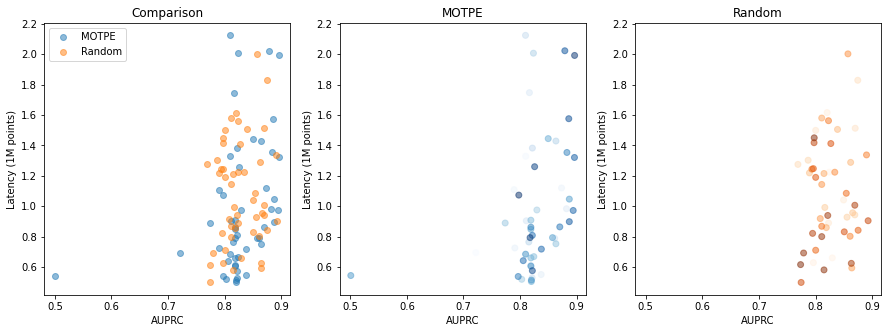

In [ ]:
three_panel_fig([motpe_df, random_df])

The figures above (if you loaded ours) show the results of 100 trials using MOTPE and 100 trials of random search to optimize the hyperparameters of our XGBoost model for the fraud dataset. The leftmost panel shows a comparison between the two optimization experiments. We see that the MOTPE strategy more densely samples in the desired region (low latency - high AUPRC) and finds many models that dominate in terms of latency (fastest models). However, random search is no slouch and ends up finding several models that dominate in terms of AUPRC (most predictive accuracy).

The middle and right panels show each experiment separately with points colored according to the trial in which they were sampled, with lighter points representing earlier trials and darker points, later trials. In the case of MOTPE, we see the lightest points are spread out over the latency-AUPRC space (this makes sense since the MOTPE algorithm is initially seeded with a few random trials), while the darker points cluster in the desirable corner. This indicates that the MOTPE algorithm is sampling strategically, attempting to identify hyperparameter configurations that optimize both objectives. 

On the other hand, the random search strategy is random throughout! Both lighter and darker orange points are widely dispersed and it was by sheer luck that this strategy landed on some of the most predictive models. But this is exactly the point -- given enough random samples, you're bound to cover a good portion of the space, including desirable regions of low latency and high AUPRC. 

Optuna also provides some nice visualizations.  Though we can't plot both studies simultaneously, these figures allow one to quickly identify the trials on the Pareto frontier (in red). Hovering over each point provides the details for that trial, including the sampled hyperparameters. 

In [ ]:
fig = optuna.visualization.plot_pareto_front(motpe_experiment, target_names=["AUPRC", "latency"])
fig.layout.title = 'Pareto-front MOTPE'
fig

<p><center><img src='https://github.com/sparsh-ai/multiobjective-optimizations/blob/main/docs/_images/T892775_6.png?raw=1'></center></p>

### Conclusion or something

In this section we considered a simple, yet real-world use case in which one might wish to consider multi-objective Bayesian optimization to select the hyperparameters of a machine learning model. We found that although BO techniques more densely sampled the most desirable region of our objective space (low latency, high AUPRC), it was only marginally better than a random sampling approach. We suspect that, given additional trials (for both experiments), BO would eventually provide a better Pareto frontier than random sampling. If your compute budget is considerable, this may be a viable option.  However, for most use cases, random sampling is likely sufficient. Either way, run as many trials as your compute budget allows. 


## Multi-objective Bayesian optimization for Approximate Nearest Neighbors search (Annoy, HNSW, LSH)

Some of the ANN algorithms explored in this section take a considerable amount of time and memory at install. They also take a long time to train during hyperparameter optimization. We've provided estimates of cell run times within the section. While we encourage experimentation and exploration, we include saved results so that execution of each cell is not strictly required.

> This section makes use of a GloVe word embeddings dataset reformatted by the ANN Benchmarks repository, a project that provides tools, code, and data for performing comparative benchmarking between various approximate neareset neighbor algorithms. However, the ANN Benchmarks library is a heavy install, designed to provide a suite of Docker containers for benchmarking purposes. We do not wish to belabor the already lengthy install for this section so we have borrowed and gently modified their dataset fetching functionality. The original can be found [here](https://github.com/erikbern/ann-benchmarks/blob/18ba39b6a4af1243b26bf5fedc6c5c7ced791d70/ann_benchmarks/datasets.py).

In [ ]:
"""
code gently modified from original source at 
https://github.com/erikbern/ann-benchmarks/blob/18ba39b6a4af1243b26bf5fedc6c5c7ced791d70/ann_benchmarks/datasets.py
"""

import h5py
import os

from urllib.request import urlretrieve


def download(src, dst):
    if not os.path.exists(dst):
        # TODO: should be atomic
        print('downloading %s -> %s...' % (src, dst))
        urlretrieve(src, dst)


def get_dataset_fn(dataset):
    if not os.path.exists('data'):
        os.mkdir('data')
    return os.path.join('data', '%s.hdf5' % dataset)


def get_dataset(which):
    hdf5_fn = get_dataset_fn(which)
    try:
        url = 'http://ann-benchmarks.com/%s.hdf5' % which
        download(url, hdf5_fn)
    except:
        print("Cannot download %s" % url)
    hdf5_f = h5py.File(hdf5_fn, 'r')

    # here for backward compatibility, to ensure old datasets can still be used with newer versions
    dimension = hdf5_f.attrs['dimension'] if 'dimension' in hdf5_f.attrs else len(hdf5_f['train'][0])

    return hdf5_f, dimension

In our previous sections we explored multi-objective Bayesian optimization (MOBO) applied to a [synthetic dataset]() and to the canonical [Credit Card Fraud dataset](). While we learned a lot from these toy experiments, we wanted to consider a more realistic use case. A good candidate for MOBO has several qualities: 
1. it should be an expensive-to-run function that could potentially benefit from efficient optimization
2. it should have multiple objectives that one might realistically strive to optimize
3. and, ideally, it should have real-world utility and a more challenging dataset

One such application that fits the bill is nearest neighbor search. In nearest neighbor search we typically have an entity represented by a vector and our goal is to indentify similar entities by finding those vectors closest to our query vector. In what follows, we explore several classes of approximate nearest neighbor search algorithms and share what we learned. 

### Nearest Neighbor Search
Nearest neighbor search is a ubiquitous and fundamental tool. It can be used to detect spam, find similar images, recognize handwritten digits, find semantically similar pieces of text, and recommend articles, music, or videos. Just about any interaction on the internet involves the application of a nearest neighbor search! A brute force solution computes the exact distance between every single pair of objects in our database. However, modern applications typically require searching over millions of objects, rendering the brute force solution impractically slow.  This has spawned a huge area of research and the development of a wide variety of Approximate Nearest Neighbor (ANN) algorithms that make neighbor searching more efficient - at a price. In many applications an exact solution, while nice to have, is not a necessity when a good approximation will work well for most instances. ANN algorithms thus sacrifice accuracy (and sometimes memory) to increase the efficiency of the search. 
Therefore, these algorithms naturally demand trade-offs between latency, accuracy and memory footprint. 

#### ANN Primer
The core idea behind the majority of ANN algorithms is that we can find an approximate solution by comparing our query point to a _subset_ of points in our database, rather than exhaustively comparing to _all_ points in our database (the brute force solution). The larger the subset we search over, the more likely we are to find the true set of nearest neighbors -- but it will take more time. If we allow the subset to equal the size of our database, we should retrieve the exact solution -- but the query would take so long that we'd lose all the users on our website who would get bored of waiting and churn off! 

Thus, the main objective for many ANN algorithms is to devise clever ways to reduce the number of items to be scored in search of the best neighbors. Often this is accomplished by proficiently partitioning the points in our database. This partitioning can be accomplished in several ways, which we can roughly group into three families of ANN algorithms.    

#### All in the fANNmily 

1. **Tree-based** \
    Trees are another classic approach to nearest neighbor search. Data points are divided hierarchically into cells and neighbors are found by traversing the tree(s). This category includes classics like k-d trees and ball trees. Like graph methods, tree-based methods have a long construction time which is especially noticeable with very large datasets.  
2. **Graph-based** \
    These algorithms first build a graph in which each item in the database is a node with the vertices representing the distance between nodes. Fast neighbor search is typically performed through greedy graph traversal. Dozens of algorithms exist in this category, including variations on graph construction and greedy  traversal methods. 
3. **Hashing-based** \
    These algorithms work by projecting the data points into lower-dimensional space using hashing. These hashes are "locality-sensitive" such that nearby points fall into the same hash bucket with high probability. Finding neighbors requires identifying bucket(s) that match the query hash. 
 

### The game plANN 
(Alright, we'll stop with the puns.) In this section we'll walk through how to apply multi-objective Bayesian optimization techniques to several ANN algorithms: **Annoy** (tree-based), **HNSW** (graph-based), and **LSH** (hashing-based), one from each of the ANN families above.  In each experiment we'll consider three objectives: accuracy, latency, and memory footprint. Our goal will be to find the 3D Pareto frontier that defines the trade-offs between these objectives. For each experiment, we'll perform multi-objective Bayesian optimization (MOBO) with the Optuna library and compare that to a quasi-random search. 

First, let's take care of some installs, imports, and the data that we'll use for this section. 

In [ ]:
import os
import psutil
import time

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import annoy
import hnswlib
import falconn
import optuna

The next cell will take care of our data needs. We'll be using GloVe word embeddings generated from tweets. In order to compare our predicted (approximate) nearest neighbors to ground truth, we'll need to use a brute force method to compute what the ground truth neighbors are for a test set. Luckily, this work has already been done by the authors of the [ANN_benchmarks](https://github.com/erikbern/ann-benchmarks/tree/3aedc8a314aba1c7d42b64e7ff9f3944e6822a93) library. They even include a helpful function for automatically downloading a train and test set along with ground truth neighbors to compare against. 

In [ ]:
# Load data for all experiments
dataset, _ = get_dataset('glove-100-angular')

# the data is structured as hd5f so we cast them to np.arrays
# there are 1.2M word embeddings in the train set
X_train = np.array(dataset['train'])
# there are 10K word embeddings in the test set
X_test = np.array(dataset['test'])
# these are the brute-force-computed ground truth neighbors for each item in the test set
X_test_neighbors = np.array(dataset['neighbors'])

These constants will be used throughout the section. For each experiment we'll look for the 10 nearest neighbors to a given query point. Each experiment will run for a minimum of 50 trials. 

In [ ]:
# for all experiments, we'll look for the 10 nearest neighbors
N_NEIGHBORS = 10
# each experiment will also be composed fo 50 rounds of optimization
N_TRIALS = 50

Next, we have a couple of utility functions for measuring the memory usage of our algorithms, computing recall, and formatting the results of an experiment. 

In [ ]:
def get_memory_usage(pid):
    # given a process ID, return the memory usage in MB
    return psutil.Process(pid).memory_info().rss / 1024 ** 2

def compute_recall(predicted_neighbors, true_neighbors):
    # given a list of neighbor predictions and ground truth neighbors
    # compute the average recall
    score = 0
    for prediction, truth in zip(predicted_neighbors, true_neighbors):
        score += len(set(prediction).intersection(truth)) / N_NEIGHBORS
    return score / len(true_neighbors)

def cast_as_df(optuna_experiment, experiment_type, algorithm_name):
    return (
        optuna_experiment
        .trials_dataframe()
        .rename(columns={"values_0": "recall", "values_1": "query_time", "values_2":"index_size"})
        .assign(experiment = experiment_type,
                algorithm = algorithm_name
               )
    )

We also include a few plotting routines. 

In [ ]:
def threeD_fig(dfs):
    fig = plt.figure(figsize=(8,8))
    ax = plt.axes(projection='3d')

    for df in dfs:
        ax.scatter3D(df["recall"], df["query_time"]*1e3, df['index_size'], alpha=0.5, label=df.reset_index().experiment[0])
    ax.set_xlabel("Recall", fontsize=12)
    ax.set_ylabel("Query time (ms)", fontsize=12)
    ax.set_zlabel("Index size (MB)")

    plt.suptitle(f"{df.reset_index().algorithm[0]} Results", fontsize=20)
    plt.tight_layout()

    
def three_panel_fig(dfs):
    fig = plt.figure(figsize=(16,6))

    ax = fig.add_subplot(131)
    for df in dfs:
        ax.scatter(df["recall"], df["query_time"]*1e3, alpha=0.5, label=df.reset_index().experiment[0])
    plt.xlabel("Recall")
    plt.ylabel("Query Time (ms)")
    plt.legend()

    ax = fig.add_subplot(132)
    for df in dfs:
        ax.scatter(df["recall"], df["index_size"], alpha=0.5, label=df.reset_index().experiment[0])
    plt.xlabel("Recall")
    plt.ylabel("Index size (MB)")
    plt.legend();

    ax = fig.add_subplot(133)
    for df in dfs:
        ax.scatter(df["query_time"]*1e3, df["index_size"], alpha=0.5, label=df.reset_index().experiment[0])
    plt.xlabel("Query time (ms)")
    plt.ylabel("Index size (MB)")
    plt.legend();
    
    plt.suptitle(f"{df.reset_index().algorithm[0]} Results", fontsize=20)

### Approximate Nearest Neighbors, Oh Yeah!

No kidding, those words compose the delightful acronym [Annoy](https://github.com/spotify/annoy). Developed by the good people at Spotify for music recommendations, the algorithm behind this library falls under the tree-based methods. While the library's author does a fantastic job describing the algorithm in [this](https://erikbern.com/2015/10/01/nearest-neighbors-and-vector-models-part-2-how-to-search-in-high-dimensional-spaces.html) blog post, we provide a brief overview here (borrowing their figures for illustration). 

At a high level, Annoy works by randomly selecting pairs of datapoints and creates a hyperplane equidistant between them to split the dataset. It does this recursively until the whole space is partitioned and each partition contains `k` datapoints. 

<p><center><img src='https://github.com/sparsh-ai/multiobjective-optimizations/blob/main/docs/_images/T892775_7.png?raw=1' style='width:500px;height:400px;'></center></p>

Next, a binary tree is constructed from these partitions and points that are close to each other in space are likely to be close to each other in the tree as well. 

<p><center><img src='https://github.com/sparsh-ai/multiobjective-optimizations/blob/main/docs/_images/T892775_8.png?raw=1' style='width:800px;height:300px;'></center></p>

This is performed many times until an entire forest is constructed. Neighbors are found by traversing the trees and only computing distances on those datapoints that fall in the same (or nearby) branches. 


### Hyperparameters
There are two main hyperparameters to consider: the number of trees (`n_trees`) to construct during build time, and the number candidate points to inspect (`search_k`) at query time. Increasing the number of trees results in better accuracy but can take more memory. Increasing the number of points to inspect also increases accuracy but takes longer. 

### Code it up
We'll use [Optuna]() to tune these hyperparameters. Below is the function we'll pass to Optuna's optimization engine. Optuna will suggest values for the hyperparameters through the `trial` object passed to the function. The function contains all the necessary pieces to build an Annoy Index and evaluate that index on the test set. The evaluation metrics include a simple computation of recall, as well as memory usage and the average query time for inference on the test set.  

In [ ]:
def train_annoy(trial):    
    # initialize the Annoy Index - requires the vector length and metric ('angular' is for cosine similarity)
    ann = annoy.AnnoyIndex(X_train.shape[1], metric='angular')

    # populate the index (build the trees) with train set
    memory_usage_before = get_memory_usage(os.getpid())
    for i, x in enumerate(X_train):
        ann.add_item(i, x.tolist())
    ann.build(n_trees = trial.suggest_int("n_trees", 10, 100))
    # measuring memory usage before and after the build 
    # will give us the size of the index in MB
    index_size = get_memory_usage(os.getpid()) - memory_usage_before

    # run queries for each example in the test set
    t1 = time.time()
    neighbors = []
    for i, x in enumerate(X_test):
        neighbors.append(ann.get_nns_by_vector(x.tolist(), 
                                               N_NEIGHBORS, 
                                               search_k = trial.suggest_int("search_k", 100, 1000)
                                              ))
    # noting the time before and after running our queries will give an
    # approximation of the average query_time
    query_time = (time.time() - t1) / len(X_test)

    recall = compute_recall(neighbors, X_test_neighbors)
    return recall, query_time, index_size

Below we specify the MOTPE (Multi-Objective Trees of Parzen Estimators) algorithm to sample hyperparameter values. In Optuna, the optimization process is called a `study`, and we pass it our sampling strategy and the `direction` we wish to optimize our metrics.  We have three objectives: predictive performance (`recall`), speed (`query_time`), and memory consumption (`index_size`). We want to `maximize` recall and `minimize` the other two. The order should align with the order in which these variables are returned from the training function above. The third line begins the optimization exercise and here we pass it the function we wish to optimize and the number of trials it should run for. 

In [ ]:
# Note: this cell takes 20-30 minutes to run
motpe_sampler = optuna.samplers.MOTPESampler()
motpe_experiment = optuna.create_study(sampler=motpe_sampler,
                                       directions=["maximize", "minimize", "minimize"])
motpe_experiment.optimize(train_annoy, n_trials=N_TRIALS)

<ipython-input-8-c8caf536b12c>:1: ExperimentalWarning: MOTPESampler is experimental (supported from v2.4.0). The interface can change in the future.
  motpe_sampler = optuna.samplers.MOTPESampler()
[I 2021-06-24 18:02:42,741] A new study created in memory with name: no-name-bb880729-97b0-4c77-8803-e339148d4e64
[I 2021-06-24 18:03:05,170] Trial 0 finished with values: [0.7299600000000024, 0.00014450559616088868, 801.37109375] and parameters: {'n_trees': 25, 'search_k': 569}. 
[I 2021-06-24 18:03:23,703] Trial 1 finished with values: [0.6031800000000012, 9.578409194946289e-05, 909.98046875] and parameters: {'n_trees': 24, 'search_k': 283}. 
[I 2021-06-24 18:04:25,494] Trial 2 finished with values: [0.8044399999999984, 0.00023747572898864745, 1981.5859375] and parameters: {'n_trees': 98, 'search_k': 635}. 
[I 2021-06-24 18:05:13,503] Trial 3 finished with values: [0.7083799999999989, 0.00016117212772369385, 1998.16015625] and parameters: {'n_trees': 74, 'search_k': 372}. 
[I 2021-06-24 18

[I 2021-06-24 18:21:23,797] Trial 44 finished with values: [0.7817899999999973, 0.00017605998516082765, 695.63671875] and parameters: {'n_trees': 13, 'search_k': 936}. 
[I 2021-06-24 18:21:35,373] Trial 45 finished with values: [0.7119300000000002, 0.00014063560962677003, 706.6796875] and parameters: {'n_trees': 10, 'search_k': 687}. 
[I 2021-06-24 18:21:53,367] Trial 46 finished with values: [0.7334200000000008, 0.00014655680656433105, 902.859375] and parameters: {'n_trees': 21, 'search_k': 612}. 
[I 2021-06-24 18:22:16,122] Trial 47 finished with values: [0.7953299999999996, 0.0001865869998931885, 842.125] and parameters: {'n_trees': 28, 'search_k': 817}. 
[I 2021-06-24 18:22:31,404] Trial 48 finished with values: [0.7773999999999993, 0.00017059760093688964, 697.41796875] and parameters: {'n_trees': 14, 'search_k': 893}. 
[I 2021-06-24 18:22:55,605] Trial 49 finished with values: [0.7425200000000012, 0.0001503593921661377, 1178.1640625] and parameters: {'n_trees': 33, 'search_k': 566

Want to run more trials? Optuna makes it easy. Simply keep running the experiment!

In [ ]:
# (OPTIONAL) run an additional N_TRIALS 
# motpe_experiment.optimize(train_annoy, n_trials=N_TRIALS)

Setting up an experiment that uses random sampling (rather than the fancy MOTPE strategy) is similarly straightforward. Just change the sampler!

In [ ]:
# Note: this cell takes 20-30 minutes to run
random_sampler = optuna.samplers.RandomSampler()
random_experiment = optuna.create_study(sampler=random_sampler, directions=["maximize", "minimize", "minimize"])
random_experiment.optimize(train_annoy, n_trials=N_TRIALS)

[I 2021-06-24 18:25:38,503] A new study created in memory with name: no-name-4b99c314-d172-4807-80a7-e6272f5bec81
[I 2021-06-24 18:26:29,808] Trial 0 finished with values: [0.6405900000000024, 0.0001361593723297119, 1994.2421875] and parameters: {'n_trees': 81, 'search_k': 244}. 
[I 2021-06-24 18:27:28,174] Trial 1 finished with values: [0.610740000000003, 0.0001340374231338501, 1989.5] and parameters: {'n_trees': 95, 'search_k': 195}. 
[I 2021-06-24 18:27:44,941] Trial 2 finished with values: [0.775880000000001, 0.0001720470905303955, 909.9296875] and parameters: {'n_trees': 16, 'search_k': 848}. 
[I 2021-06-24 18:28:10,219] Trial 3 finished with values: [0.7087000000000028, 0.00013290958404541016, 1176.19140625] and parameters: {'n_trees': 31, 'search_k': 474}. 
[I 2021-06-24 18:29:05,679] Trial 4 finished with values: [0.6768700000000033, 0.00016857590675354003, 1920.81640625] and parameters: {'n_trees': 88, 'search_k': 295}. 
[I 2021-06-24 18:29:48,169] Trial 5 finished with values

[I 2021-06-24 18:54:58,392] Trial 45 finished with values: [0.7507200000000016, 0.00015626652240753174, 824.8046875] and parameters: {'n_trees': 23, 'search_k': 659}. 
[I 2021-06-24 18:55:15,463] Trial 46 finished with values: [0.7031799999999997, 0.00013080110549926758, 946.61328125] and parameters: {'n_trees': 19, 'search_k': 528}. 
[I 2021-06-24 18:56:17,086] Trial 47 finished with values: [0.7725799999999986, 0.00021990971565246582, 1964.546875] and parameters: {'n_trees': 97, 'search_k': 515}. 
[I 2021-06-24 18:56:46,749] Trial 48 finished with values: [0.7408799999999989, 0.00015285589694976807, 1171.859375] and parameters: {'n_trees': 41, 'search_k': 525}. 
[I 2021-06-24 18:57:42,778] Trial 49 finished with values: [0.533529999999999, 0.00011064469814300537, 1928.34765625] and parameters: {'n_trees': 92, 'search_k': 130}. 


In [ ]:
# (OPTIONAL) run an additional N_TRIALS
# random_experiment.optimize(train_annoy, n_trials=N_TRIALS)

The output of these experiments include a Pandas dataframe summarizing the results. We created a wrapper to format that output in a nicer way. 

In [ ]:
annoy_motpe_df = cast_as_df(motpe_experiment, experiment_type="MOTPE", algorithm_name="Annoy")
annoy_random_df = cast_as_df(random_experiment, experiment_type="Random", algorithm_name="Annoy")

Let's look at the results! 

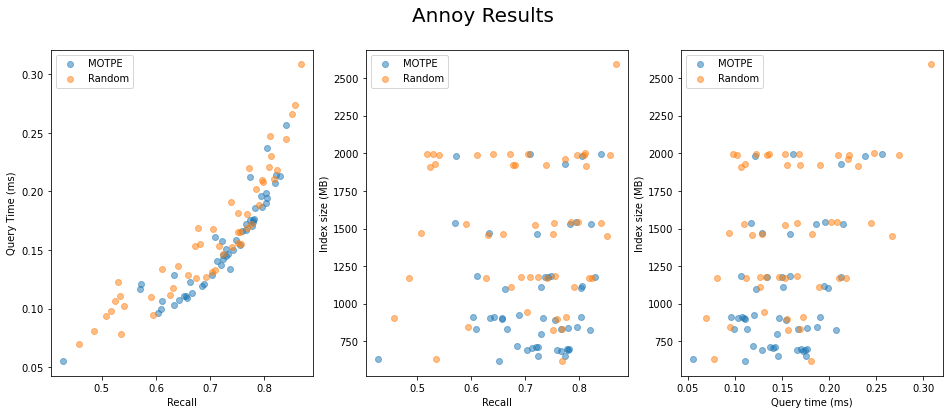

In [ ]:
three_panel_fig([annoy_motpe_df, annoy_random_df])#
#threeD_fig([motpe_df, random_df])

### Discussion time
Let's unpack this a bit. We had three objectives to optimize: recall, latency, and memory. In the figure above we show the relationship between all possible combinations of objectives (rather than showing a 3D scatter plot, which, while cool, is harder to glean useful information from. If you're hankering for some 3D, uncomment the other fig command and have at it).

The leftmost panel shows the resulting `query_time` vs `recall` and a lovely curve demonstrating the trade-off between these two objectives.  The blue MOTPE points seem to be more densely clustered closer to the edge of the latency-recall Pareto frontier. However, the orange points sample it well enough. That these two distributions are so similar is not actually a surprise. It turns out that the `search_k` parameter is explicitly designed to directly control this trade-off: larger values of `search_k` result in higher accuracy _and_ longer query times. This means that tracing out the Pareto frontier is almost entirely a matter of fixing `n_trees` (our other hyperparameter), and sweeping over `search_k`. The results would yield a similar curve. 

If those were the only two objectives we cared about, we'd be done! But since we also care about memory, the problem is a bit more complex. In the middle and third panels, we see Index size (in MB) vs the other two objectives, and here we see a bit more difference between the MOTPE algorithm and randomly sampled hyperparameter values. The MOTPE algorithm better samples the regions we care about (low memory, fast query times, and high recall), but it's not always a significant difference, even when we run for many more trials! 

<p><center><img src='https://github.com/sparsh-ai/multiobjective-optimizations/blob/main/docs/_images/T892775_9.png?raw=1'></center></p>

Some other things to note: 
1. To run the optimization in a realistic amount of time, we provided the Annoy algorithm with artifically low values for its hyperparameters. The algorithm is fairly competitive and can achieve much better recall on the GloVe dataset. However, the build and query times associated with these preferrable hyperparameter values result in an optimization time on the order of several hours. It a pesky, double-edged sword: while we want to demonstrate realistic use cases / algorithms / datasets, they come with realistic compute times which are _considerable_. 
2. It's important to keep in mind that it may not be physically possible to densely sample the entire 3D output objective volume -- there is no guarantee that combinations of hyperparameters exist such that all white space could be covered by orange or blue points. 

So why didn't MOBO run circles around random search? Maybe Annoy doesn't have enough hyperparameters to optimize over. Maybe it's just too simple. We'll come back to this discussion towards the end. For now, let's try our next ANN, which has three hyperparameters. 

### Hierarchical Navigable Small Worlds

A classic brute-force method for computing nearest neighbors to a query point is to construct a KNN graph. While these work great for small datasets, they don't scale well to millions of points. Enter Hierarchical Navigable Small Worlds (HNSW) graphs. The name says a lot so let's break it down. 

A "small world" graph (or network) is one in which the nodes are highly clustered (most nodes are not neighbors of one another), but the _neighbors_ of any give node are likely to be neighbors of _each other_, resulting in a graph in which most nodes can be reached by every other node in only a few steps. While that might seem paradoxical, think of the distribution of air traffic. Planes fly mostly from busy, centralized hubs (highly clustered), and it only takes a few stop-overs to go from your local airport to just about any major city in the world. 

If we could structure our dataset in such a way that it has the properties of a small world graph, we'd be in decent shape because we could quickly find neighbors anywhere in the graph in a small number of steps. In practice, though, that's not enough. Tracing along the nodes in a graph still takes linear time (it takes _n_ time steps to move _n_ nodes). However, if a small world graph is also _navigable_ then it possesses an additional property: routing through the graph can be done on a logarathimic scale (those same _n_ nodes can now be traversed in only _log(n)_ time), which is much faster! But we can do even better.

We finally come to the "heirarchical" part. The HNSW algorithm constructs a hierarchy of NSW graphs. The first layer is a graph of all the points in our database, where each point is connected to others on a small, characteristic scale length. Next, a subset of these points is kicked up to a second layer, where these points are connected via a slightly longer scale length. Then a subset of this subset is kicked up to a third layer with an even larger scale length connection, and so on.

<p><center><img src='https://github.com/sparsh-ai/multiobjective-optimizations/blob/main/docs/_images/T892775_10.png?raw=1'></center></p>

When a query comes in, the algorithm starts at the top layer, greedily searching for nearest neighbors on the graph with the longest scale length. The results of this layer are then passed down to the layer below, where new, closer neighbors are found. This continues until the algorithm reaches lowest layer, finally returning the closest neighbors.  


### Hyperparameters
We'll use the [hnswlib](https://github.com/nmslib/hnswlib) library for this algorithm. This implementation has three tunable hyperparameters. 
* `ef` sets the size of the dynamic list of candidates to evaluate at query time. This parameter affects the latency-recall trade-off, where large values of `ef` yield better accuracy but longer query times. 
* `ef_construction`: This has the same meaning as `ef` but during the construction phase. It influences the construction time as well as the quality of the index. Larger values result in a better index but take longer to build.  
* `M`: this sets the number of bidirectional connections between nodes in the graph. More nodes mean more memory usage but also better connections between other nodes. Larger values of `M` are often better for high-dimensional vectors (like the word embeddings we're using).  


### Code it up
Very little changes from our previous function! We still initialize and populate an index even though, behind the scenes, the algorithm is constructing a very different object from the Annoy algorithm. 

In [ ]:
def train_hnsw(trial): 
    
    ann = hnswlib.Index(space='cosine', dim=X_train.shape[1])
    
    num_elements = len(X_train)
    
    # Initializing index - the maximum number of elements should be known beforehand
    memory_usage_before = get_memory_usage(os.getpid())
    ann.init_index(max_elements = num_elements, 
                   ef_construction = trial.suggest_int("ef_construction", 10, 100), 
                   M = trial.suggest_int("M", 2, 50)
                  )
    # Element insertion 
    ann.add_items(X_train, np.arange(num_elements))
    index_size = get_memory_usage(os.getpid()) - memory_usage_before

    # control the recall (ef should always be >= N_NEIGHBORS)
    ann.set_ef(trial.suggest_int("ef", 10, 100)) 

    # run queries for each example in the test set
    t1 = time.time()
    # Query dataset, k - number of closest elements (returns 2 numpy arrays)
    neighbors, _ = ann.knn_query(X_test, k = N_NEIGHBORS)
    query_time = (time.time() - t1) / len(X_test)

    recall = compute_recall(neighbors, X_test_neighbors)
    
    return recall, query_time, index_size

In [ ]:
# NOTE: this cell takes about an hour to run
motpe_sampler = optuna.samplers.MOTPESampler()
motpe_experiment = optuna.create_study(sampler=motpe_sampler,
                                       directions=["maximize", "minimize", "minimize"])
motpe_experiment.optimize(train_hnsw, n_trials=N_TRIALS)

<ipython-input-13-1db9ede7d8eb>:1: ExperimentalWarning: MOTPESampler is experimental (supported from v2.4.0). The interface can change in the future.
  motpe_sampler = optuna.samplers.MOTPESampler()
[I 2021-06-24 19:03:32,672] A new study created in memory with name: no-name-95a55001-4570-4d8f-9543-c0a88604b11a
[I 2021-06-24 19:03:43,053] Trial 0 finished with values: [0.26542999999999495, 8.561468124389648e-06, 674.1875] and parameters: {'ef_construction': 51, 'M': 2, 'ef': 71}. 
[I 2021-06-24 19:06:18,716] Trial 1 finished with values: [0.991349999999999, 7.11815357208252e-05, 1399.38671875] and parameters: {'ef_construction': 32, 'M': 96, 'ef': 33}. 
[I 2021-06-24 19:06:45,629] Trial 2 finished with values: [0.784400000000004, 1.891188621520996e-05, 622.87890625] and parameters: {'ef_construction': 39, 'M': 10, 'ef': 33}. 
[I 2021-06-24 19:08:59,683] Trial 3 finished with values: [0.9920599999999989, 7.491040229797363e-05, 1309.55078125] and parameters: {'ef_construction': 79, 'M': 

[I 2021-06-24 20:06:49,033] Trial 42 finished with values: [0.9911199999999997, 7.964971065521241e-05, 738.58984375] and parameters: {'ef_construction': 53, 'M': 25, 'ef': 90}. 
[I 2021-06-24 20:08:01,295] Trial 43 finished with values: [0.9795499999999984, 5.242159366607666e-05, 658.45703125] and parameters: {'ef_construction': 78, 'M': 16, 'ef': 71}. 
[I 2021-06-24 20:09:23,540] Trial 44 finished with values: [0.9883000000000002, 7.203876972198486e-05, 704.921875] and parameters: {'ef_construction': 79, 'M': 21, 'ef': 68}. 
[I 2021-06-24 20:12:36,768] Trial 45 finished with values: [0.9993, 0.00015685410499572755, 1380.41796875] and parameters: {'ef_construction': 62, 'M': 96, 'ef': 82}. 
[I 2021-06-24 20:13:03,193] Trial 46 finished with values: [0.7359600000000042, 2.223978042602539e-05, 560.40234375] and parameters: {'ef_construction': 57, 'M': 5, 'ef': 71}. 
[I 2021-06-24 20:13:58,171] Trial 47 finished with values: [0.9367900000000003, 4.296810626983643e-05, 623.61328125] and pa

In [ ]:
# Note: this cell can take 1-2 hours to run
random_sampler = optuna.samplers.RandomSampler()
random_experiment = optuna.create_study(sampler=random_sampler, directions=["maximize", "minimize", "minimize"])
random_experiment.optimize(train_hnsw, n_trials=N_TRIALS)

[I 2021-06-24 20:25:37,665] A new study created in memory with name: no-name-a68eff9b-eb2b-4f18-bfc7-d4165162ea33
[I 2021-06-24 20:28:06,180] Trial 0 finished with values: [0.983939999999999, 5.984342098236084e-05, 1276.7578125] and parameters: {'ef_construction': 84, 'M': 85, 'ef': 29}. 
[I 2021-06-24 20:28:44,845] Trial 1 finished with values: [0.979860000000001, 7.119548320770264e-05, 804.00390625] and parameters: {'ef_construction': 36, 'M': 32, 'ef': 89}. 
[I 2021-06-24 20:30:52,545] Trial 2 finished with values: [0.9822999999999993, 7.502460479736328e-05, 1203.10546875] and parameters: {'ef_construction': 37, 'M': 77, 'ef': 32}. 
[I 2021-06-24 20:32:44,439] Trial 3 finished with values: [0.9970999999999997, 9.25718069076538e-05, 884.734375] and parameters: {'ef_construction': 81, 'M': 41, 'ef': 77}. 
[I 2021-06-24 20:32:59,959] Trial 4 finished with values: [0.7970900000000032, 2.7109718322753907e-05, 668.33984375] and parameters: {'ef_construction': 15, 'M': 17, 'ef': 47}. 
[I 2

[I 2021-06-24 22:02:40,147] Trial 43 finished with values: [0.8827200000000018, 2.7303791046142577e-05, 902.71875] and parameters: {'ef_construction': 25, 'M': 43, 'ef': 20}. 
[I 2021-06-24 22:04:13,108] Trial 44 finished with values: [0.9580099999999994, 4.920849800109863e-05, 1110.40234375] and parameters: {'ef_construction': 64, 'M': 66, 'ef': 28}. 
[I 2021-06-24 22:06:12,731] Trial 45 finished with values: [0.9991300000000001, 0.0001390671968460083, 1218.75] and parameters: {'ef_construction': 55, 'M': 78, 'ef': 92}. 
[I 2021-06-24 22:07:12,461] Trial 46 finished with values: [0.9388200000000008, 3.362522125244141e-05, 631.83984375] and parameters: {'ef_construction': 84, 'M': 13, 'ef': 50}. 
[I 2021-06-24 22:07:54,610] Trial 47 finished with values: [0.795320000000003, 1.5109610557556152e-05, 695.0390625] and parameters: {'ef_construction': 46, 'M': 20, 'ef': 14}. 
[I 2021-06-24 22:10:18,765] Trial 48 finished with values: [0.9802700000000001, 5.933408737182617e-05, 1327.11328125]

In [ ]:
hnsw_motpe_df = cast_as_df(motpe_experiment, experiment_type="MOTPE", algorithm_name="HNSW")
hnsw_random_df = cast_as_df(random_experiment, experiment_type="Random", algorithm_name="HNSW")

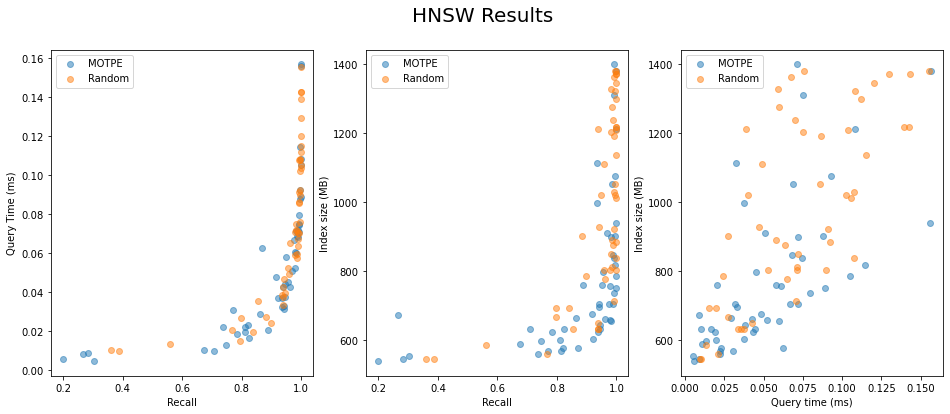

In [ ]:
three_panel_fig([hnsw_motpe_df, hnsw_random_df])#

### Discussion time

Results are essentially the same with this algorithm. Even though we have more hyperparameters (3 for HNSW vs only 2 for Annoy), random sampling is able to effectively cover similar regions of the objective space. Again, we ran this experiment for 100 trials (which took a looong time). 


<p><center><img src='https://github.com/sparsh-ai/multiobjective-optimizations/blob/main/docs/_images/T892775_11.png?raw=1'></center></p>

One intriguing difference is in the middle figure where the MOTPE algorithm identifies a few models that seem to dominate the memory space (having much lower memory than all other models) but this is likely a fluke because the way we  measure memory usage of the algorithm is not exact. 

### Locality-sensitive Hashing

A _hash function_ maps high-dimensional data to fixed-size low-dimensional representations. The outputs of hash functions are typically used as keys into _hash tables_.  In cryptography and security applications, hash functions are designed such that two datapoints (ideally) never map to the same output. But _locality-sensitive_ hash functions do just the opposite -- they are designed such that similar data points _collide_ with high probability, that is, they land in the same _bucket_. Thus, hash functions are another method to partition our dataset, reducing the amount of computation.  LSH strives to ensure similar points fall into the same bucket, and dissimilar points land in other buckets. At query time, we apply our hash function to the incoming query, match the hash output to the corresponding bucket, and examine only those database points residing in that same bucket. 

<p><center><img src='https://github.com/sparsh-ai/multiobjective-optimizations/blob/main/docs/_images/T892775_12.png?raw=1'></center></p>

In reality, multiple hash functions are used, each resulting in a slightly different partitioning of the space.   When the query comes in, each hash function is applied to the query point and candidates from the matching bucket from _each_ hash table are retrieved.  

A hash table can have lots of buckets or only a few buckets, determined by the number of _bits_. More bits equal more buckets. More buckets result in a finer partitioning of the space. For example, imagine we randomly mapped each point in our database to either 0 or 1 (two bits = two buckets). We'd have approximately half our database in each bucket. When performing a query, we'll retrieve all the members of, say, bucket 0. We'll still have to compute the distances between our query and _half_ the points in our database! Therefore, more bits usually reduces the query time by thinning out the number of candidates in each bucket. 

### Hyperparameters
While there are literally dozens of implementations, most versions (including the version we use) have the following hyperparameters to consider: 

* `number_of_hash_tables`: More hash tables lead to better accuracy but increased memory footprint.  
* `number_of_hash_bits`: The number of hash bits determines the number of buckets per table; more buckets decreases query time but increases the memory footprint. 
* `number_of_probes`: At query time, we can examine multiple buckets from each hash table to find nearest neighbor candidates. More probes leads to great accuracy but the query will take longer. 


### Code it up
We're using the [FALCONN](https://github.com/FALCONN-LIB/FALCONN) library for LSH (in case you're wondering, FALCONN is the decidedly awkward acronym for FAst Lookups of Cosine and Other Nearest Neighbors). We found this library to be a bit finicky, and it requires a sizeable amount of prepwork before index initialization. We borrowed from [this example](https://github.com/FALCONN-LIB/FALCONN/blob/master/src/examples/glove/glove.py), where you can find more details about these additional (non-tunable) parameters. 

**Special note:** This algorithm is structured in such a way that the `number_of_probes` used at query time _must_ be at least as large as the `number_of_tables`. This means we have one hyperparameter that is directly dependent on another! Thankfully, Optuna handles this use case with aplomb! Optuna's enables define-by-run optimization which means that each trial is generated entirely independently from others. Instead of assigning our HPs inline as in the previous examples, we'll handle them at the top of the function.

In [ ]:
def train_lsh(trial):
    
    # Handle hyperparameter suggestions
    num_tables = trial.suggest_int("number_of_tables", 10, 50)
    # num_probes depends on num_tables -- 
    # We can directly pass Optuna's num_tables suggestion to the num_probes generator
    num_probes = trial.suggest_int("number_of_probes", num_tables, num_tables*2) 
    # Don't allow num_bits > 28 or falconn will throw an error
    num_bits = trial.suggest_int("number_of_hash_bits", 12, 26)
    
    # LSH initialization (For more details see link to example above)
    params = falconn.LSHConstructionParameters()
    params.dimension = len(X_train[0])
    params.lsh_family = falconn.LSHFamily.CrossPolytope
    params.distance_function = falconn.DistanceFunction.EuclideanSquared
    params.num_rotations = 1
    params.seed = 5721840 
    params.num_setup_threads = 0 # use all available threads
    params.storage_hash_table = falconn.StorageHashTable.BitPackedFlatHashTable
    # Set build-related hyperparameters
    params.l = num_tables
    falconn.compute_number_of_hash_functions(num_bits, params)

    # LSH index construction
    memory_usage_before = get_memory_usage(os.getpid())
    table = falconn.LSHIndex(params)
    table.setup(X_train)
    index_size = get_memory_usage(os.getpid()) - memory_usage_before

    # Set up the query object with num_probes
    query_object = table.construct_query_object(num_probes=num_probes) 
    
    # Perform the queries
    t1 = time.time()
    neighbors = []
    for i, x in enumerate(X_test):
        neighbors.append(query_object.find_k_nearest_neighbors(x, N_NEIGHBORS))
    query_time = (time.time() - t1) / len(X_test)
                         
    # Evaluate
    recall = compute_recall(neighbors, X_test_neighbors)

    return recall, query_time, index_size

In [ ]:
# Note: this cell takes about 20 minutes to run
motpe_sampler = optuna.samplers.MOTPESampler()
motpe_experiment = optuna.create_study(sampler=motpe_sampler,
                                       directions=["maximize", "minimize", "minimize"])
motpe_experiment.optimize(train_lsh, n_trials=N_TRIALS)

<ipython-input-21-236ef6d9d285>:1: ExperimentalWarning: MOTPESampler is experimental (supported from v2.4.0). The interface can change in the future.
  motpe_sampler = optuna.samplers.MOTPESampler()
[I 2021-06-25 09:51:36,492] A new study created in memory with name: no-name-4bbb0127-2e15-433d-9c12-3219ddfe1e92
[I 2021-06-25 09:52:09,918] Trial 0 finished with values: [0.8797599999999849, 0.002646678829193115, 168.66796875] and parameters: {'number_of_tables': 48, 'number_of_probes': 65, 'number_of_hash_bits': 15}. 
[I 2021-06-25 09:52:31,149] Trial 1 finished with values: [0.4578599999999973, 0.00046552860736846926, 2718.35546875] and parameters: {'number_of_tables': 43, 'number_of_probes': 83, 'number_of_hash_bits': 24}. 
[I 2021-06-25 09:52:41,046] Trial 2 finished with values: [0.37286999999998993, 0.00021935951709747316, 742.484375] and parameters: {'number_of_tables': 23, 'number_of_probes': 44, 'number_of_hash_bits': 23}. 
[I 2021-06-25 09:52:56,552] Trial 3 finished with values

[I 2021-06-25 10:04:02,085] Trial 36 finished with values: [0.9164999999999814, 0.004724530696868896, 174.75] and parameters: {'number_of_tables': 47, 'number_of_probes': 92, 'number_of_hash_bits': 14}. 
[I 2021-06-25 10:04:17,020] Trial 37 finished with values: [0.6072200000000012, 0.0004701333045959473, 310.43359375] and parameters: {'number_of_tables': 42, 'number_of_probes': 58, 'number_of_hash_bits': 20}. 
[I 2021-06-25 10:04:30,403] Trial 38 finished with values: [0.659839999999997, 0.0005370358943939208, 139.46484375] and parameters: {'number_of_tables': 32, 'number_of_probes': 43, 'number_of_hash_bits': 18}. 
[I 2021-06-25 10:05:35,044] Trial 39 finished with values: [0.9189799999999837, 0.005846633505821228, 144.9609375] and parameters: {'number_of_tables': 38, 'number_of_probes': 74, 'number_of_hash_bits': 13}. 
[I 2021-06-25 10:05:50,321] Trial 40 finished with values: [0.6989299999999935, 0.0006446422576904297, 164.7109375] and parameters: {'number_of_tables': 39, 'number_o

In [ ]:
# Note: this cell takes about 20 minutes to run
random_sampler = optuna.samplers.RandomSampler()
random_experiment = optuna.create_study(sampler=random_sampler, directions=["maximize", "minimize", "minimize"])
random_experiment.optimize(train_lsh, n_trials=N_TRIALS)

[I 2021-06-25 10:16:26,401] A new study created in memory with name: no-name-fba75b23-62b5-45e2-8188-8631152733c7
[I 2021-06-25 10:16:46,174] Trial 0 finished with values: [0.7781999999999899, 0.0010494932889938355, 146.73046875] and parameters: {'number_of_tables': 40, 'number_of_probes': 55, 'number_of_hash_bits': 17}. 
[I 2021-06-25 10:17:21,762] Trial 1 finished with values: [0.2764099999999897, 0.00046885650157928464, 5098.8984375] and parameters: {'number_of_tables': 34, 'number_of_probes': 61, 'number_of_hash_bits': 26}. 
[I 2021-06-25 10:17:46,242] Trial 2 finished with values: [0.8394799999999893, 0.0018278647184371947, 114.30078125] and parameters: {'number_of_tables': 34, 'number_of_probes': 45, 'number_of_hash_bits': 15}. 
[I 2021-06-25 10:18:55,244] Trial 3 finished with values: [0.9209299999999814, 0.0062559912919998165, 155.18359375] and parameters: {'number_of_tables': 41, 'number_of_probes': 75, 'number_of_hash_bits': 13}. 
[I 2021-06-25 10:19:12,738] Trial 4 finished 

[I 2021-06-25 10:31:32,167] Trial 37 finished with values: [0.8966099999999849, 0.003543233299255371, -490.703125] and parameters: {'number_of_tables': 49, 'number_of_probes': 58, 'number_of_hash_bits': 14}. 
[I 2021-06-25 10:31:54,924] Trial 38 finished with values: [0.8315899999999902, 0.001818433904647827, 110.1484375] and parameters: {'number_of_tables': 25, 'number_of_probes': 47, 'number_of_hash_bits': 15}. 
[I 2021-06-25 10:32:14,844] Trial 39 finished with values: [0.20976999999999385, 0.00020131540298461915, 3590.08984375] and parameters: {'number_of_tables': 21, 'number_of_probes': 40, 'number_of_hash_bits': 26}. 
[I 2021-06-25 10:32:21,519] Trial 40 finished with values: [0.21414999999999368, 0.00012017819881439209, 779.625] and parameters: {'number_of_tables': 14, 'number_of_probes': 15, 'number_of_hash_bits': 23}. 
[I 2021-06-25 10:32:28,350] Trial 41 finished with values: [0.4030499999999927, 0.0001993230104446411, -12.57421875] and parameters: {'number_of_tables': 14, 'n

In [ ]:
lsh_motpe_df = cast_as_df(motpe_experiment, experiment_type="MOTPE", algorithm_name="LSH")
lsh_random_df = cast_as_df(random_experiment, experiment_type="Random", algorithm_name="LSH")

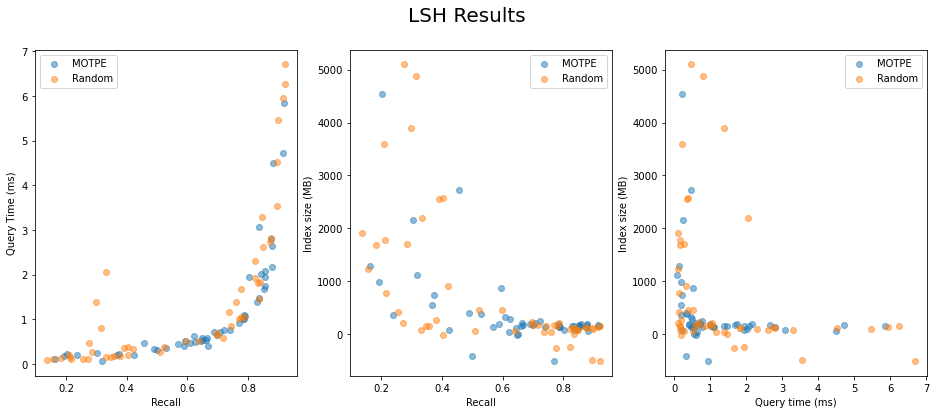

In [ ]:
three_panel_fig([lsh_motpe_df, lsh_random_df])#

### Discussion time
These figures look much the same as previous experiments: both MOTPE and random sampling more or less trace out the same region of objective space. Again, we find a few points that seem to dominate the memory space but again we caution that this is likely due to the nature in which we measure memory (in fact, we know some of these measurements are completely wrong because they're negative!). We use the `psutil` library and pass it the process PID to measure the memory usage before and after building the index. While this works well enough for Annoy and HNSW, we suspect this LSH implementation does not always fully release memory upon a new iteration of a trial during the optimization run. This would cause the next pass through the training loop to still register memory from the previous loop, thus resulting in an incorrect measurement. We were unable to track down the exact cause -- if we figure it out, we'll fix it! (And if you spot the problem, let us know!)


<p><center><img src='https://github.com/sparsh-ai/multiobjective-optimizations/blob/main/docs/_images/T892775_13.png?raw=1'></center></p>

To be consistent, we again ran this experiment for many more trials (150 this time). While we can see Pareto frontier is very densely sampled by the MOBO strategy, random search still does a fine job of covering the space. 

### Optimizing ANNs without MOBO

We used ANNs to demonstrate a real-world, complex, data-intensive application with realistic multi-objective goals. This allowed us to explore the nuances of multi-objective optimization on more than a toy problem. But we ultimately discovered that even in such a setting, multi-objective Bayesian optimization does not typically perform significantly better than random sampling.  However, if you are building an ANN application (rather than reading along for a detailed look at MOBO) then we can do even better than random sampling. 

In real ANN applications, often the memory budget is already known (or is cheap enough that additional resources can be easily procured). If you already know your memory budget, then there is no need to optimize over it. For most ANN algorithms, the memory budget can be set to your specifications with a little fiddling (think `M` in the case of HNSW, or `number_of_hash_tables` in LSH). Once set, perform a simple sweep over the hyperparameter that controls the latency-recall tradeoff (`search_k` in Annoy, `ef` in HNSW, `number_of_probes` in LSH). And voila! This hyperparameter sweep will inherently trace out a Pareto frontier in Recall/Query time space. However, if you do not know _a priori_ what memory budget you are willing to allot for your application, the next best thing would be to perform a random sampling of the hyperparameters of your algorithm to get a feel for the trade-offs involved. 

Another interesting axis we didn't dig into in this post is an ANN algorithm's _build time_. We looked closely at _query time_, which is typically more important. In this section, we artifically set the range of hyperparameter values such that cells won't take hours or _days_ to run (resulting in some rather low values of Recall, if you noticed). However, in a real application, building the search index for one of these algorithms can take a considerable amount of time when more appropriate HPs are employed and even larger datasets are used. This matters if an application will require _rebuilding_ on a regular cadence. While some algorithms allow insertion of new datapoints, better results are often achieved by occasionally rebuilding the index, especially if many new items are to be added. 

A good example is tweets. More than 500 million new tweets are added to Twitter each day. Simple insertion of these new tweets to an existing index may be suboptimal. In which case, a regular rebuilding cadence should be established and the build time for such an algorithm becomes important. Therefore, some applications may require a careful analysis of the trade-off of build time with recall, query time, and memory footprint -- a 4D optimization problem! However, as with the memory footprint, an acceptable build time budget may already be known _a priori_ and hyperparameters can be set such that they meet memory and build time requirements. Then, simply sweep over the latency-recall trade-off hyperparameter to identify the Pareto frontier between predictive performance and inference time.

## The big take-away

We applied multi-objective Bayesian optimization to three Approximate Nearest Neighbor algorithms and found that the results weren't always much better than using a random sampling. And this is not altogether unsurprising. In a [recent paper](https://arxiv.org/pdf/2012.03826.pdf), authors demonstrated that many MOBO algorithms only perform HPO a few percent better (in terms of optimizing an appropriate objective like accuracy) than random sampling on a wide range of machine learning experiments. 

While its still unclear when MOBO might provide significant gains over random sampling, one clue may be in the relationship of the hyperparameters to the objective space. Algorithms like neural networks have many parameters with complex and non-linear relationships between them and the objective (such as accuracy or latency). The myriad hyperparameter combinations could very well map to a vast space of possible (accuracy, latency) outputs (like on the right). However, this might not hold true for all algorithms, where the actual possible output space is constrained (like on the left).

<p><center><img src='https://github.com/sparsh-ai/multiobjective-optimizations/blob/main/docs/_images/T892775_14.png?raw=1'></center></p>

We speculate that MOBO optimization techniques stand a chance of performing better when the output space is like that on the right. The sophisticated mechanisms in these techniques should be better able to identify more ideal points in the output space over a random algorithm which samples, well... randomly! But when the output space is constrained, both MOBO and random search have "less room" to sample, so random performs about as well as these more sophisticated techniques. 

<p><center><img src='https://github.com/sparsh-ai/multiobjective-optimizations/blob/main/docs/_images/T892775_15.png?raw=1'></center></p>

The hyperparameters of many approximate nearest neighbor algorithms may provide their own constraints, because they often control a single objective. For example, `M` in the HNSW algorithm is almost entirely responsible for the memory footprint. This means that, regardless of the value of other hyperparmeters, the memory output is more or less fixed, constraining the possible outputs in the objective space. The same is true for the hyperparameters that control the accuracy-latency trade-off. Thus, when we plot these results we see both random and MOBO algorithms perform similarly because there simply isn't that much output space to explore. 

The ultimate lesson from our experiments in this and our previous sections is that random sampling is probably good enough for most applications. Using more sophisticated optimization techniques may provide added benefit when the relationship between your hyperparameters and the objective space is murky, or when you have a large compute budget. The longer these experiments are run, the more likely the MOBO algorithm is to find marginally better solutions and sometimes even a marginal improvement is worth the computational cost. 